# CREDIT RIKS SCORING

## IMPORT LIBRARIES

In [303]:
from scipy.io import arff
import pandas as pd

from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.auto import tqdm

from pathlib import Path


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import export_text
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mutual_info_score

import xgboost as xgb

## READ DATASET

- The dataset stored in the `dataset` folder.
- The dataset stored as `arff` format
- Or download and stored it at `dataset` folder.

In [301]:
data_path = Path('../dataset/')
data_path.mkdir(parents=True, exist_ok=True)

if Path.is_file(Path('../dataset/dataset_31_credit-g.arff')):
    print('File exists')
else:
    !wget https://www.openml.org/data/download/31/dataset_31_credit-g.arff
    !mv dataset_31_credit-g.arff ../dataset/dataset_31_credit-g.arff

File exists


In [ ]:
def getData(dataPath: str) ->pd.DataFrame:
    
    data = arff.loadarff(dataPath)
    
    df_data = pd.DataFrame(data[0])
    df_col = pd.DataFrame(data[1])
    
    return df_data, df_col

dataPath = "../dataset/dataset_31_credit-g.arff"
df_data, df_col = getData(dataPath)
df_data.head()

checking_status  duration                     credit_history  \
0           b'<0'       6.0  b'critical/other existing credit'   
1     b'0<=X<200'      48.0                   b'existing paid'   
2  b'no checking'      12.0  b'critical/other existing credit'   
3           b'<0'      42.0                   b'existing paid'   
4           b'<0'      24.0              b'delayed previously'   

                  purpose  credit_amount       savings_status employment  \
0             b'radio/tv'         1169.0  b'no known savings'     b'>=7'   
1             b'radio/tv'         5951.0              b'<100'  b'1<=X<4'   
2            b'education'         2096.0              b'<100'  b'4<=X<7'   
3  b'furniture/equipment'         7882.0              b'<100'  b'4<=X<7'   
4              b'new car'         4870.0              b'<100'  b'1<=X<4'   

   installment_commitment        personal_status other_parties  ...  \
0                     4.0         b'male single'       b'none'  ...   
1                     2.0  b'female div/dep/mar'       b'none'  ...   
2                     2.0         b'male single'       b'none'  ...   
3                     2.0         b'male single'  b'guarantor'  ...   
4                     3.0         b'male single'       b'none'  ...   

     property_magnitude   age  other_payment_plans      housing  \
0        b'real estate'  67.0              b'none'       b'own'   
1        b'real estate'  22.0              b'none'       b'own'   
2        b'real estate'  49.0              b'none'       b'own'   
3     b'life insurance'  45.0              b'none'  b'for free'   
4  b'no known property'  53.0              b'none'  b'for free'   

  existing_credits                    job num_dependents  own_telephone  \
0              2.0             b'skilled'            1.0         b'yes'   
1              1.0             b'skilled'            1.0        b'none'   
2              1.0  b'unskilled resident'            2.0        b'none'   
3              1.0             b'skilled'            2.0        b'none'   
4              2.0             b'skilled'            2.0        b'none'   

  foreign_worker    class  
0         b'yes'  b'good'  
1         b'yes'   b'bad'  
2         b'yes'  b'good'  
3         b'yes'  b'good'  
4         b'yes'   b'bad'  

[5 rows x 21 columns]

## DATA CLEANSING

- clean each values for each variable

In [ ]:
def getColumnName(df_cols: pd.DataFrame) ->list():

    col_name = list()

    for col in df_col[0]:
        col_name.append(col)
    return col_name

def cleanString(df_data: pd.DataFrame, col_name: list(), numeric_cols: list()) ->pd.DataFrame:
    
    for col in col_name:
        if col not in numeric_cols:
            df_data[col] = df_data[col].apply(lambda x: str(x).replace("b", ''))
            df_data[col] = df_data[col].apply(lambda x: str(x).replace("'", ''))
            df_data[col] = df_data[col].apply(lambda x: str(x).replace(" ", "_"))            
    return df_data

def cleanClass(df_data: pd.DataFrame, col_target: str) -> pd.DataFrame:
    
    df_data[col_target] = df_data[col_target].apply(lambda x: 'good' if x == 'good' else 'bad')
    return df_data

In [ ]:
col_name = getColumnName(df_col)
categorical_cols = ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties',
                    'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']
numeric_cols = ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']
target_col = 'class'
df = cleanString(df_data, col_name, numeric_cols)
df = cleanClass(df, target_col)
display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   checking_status         1000 non-null   object 
 1   duration                1000 non-null   float64
 2   credit_history          1000 non-null   object 
 3   purpose                 1000 non-null   object 
 4   credit_amount           1000 non-null   float64
 5   savings_status          1000 non-null   object 
 6   employment              1000 non-null   object 
 7   installment_commitment  1000 non-null   float64
 8   personal_status         1000 non-null   object 
 9   other_parties           1000 non-null   object 
 10  residence_since         1000 non-null   float64
 11  property_magnitude      1000 non-null   object 
 12  age                     1000 non-null   float64
 13  other_payment_plans     1000 non-null   object 
 14  housing                 1000 non-null   o

None

checking_status  duration                  credit_history  \
0              <0       6.0  critical/other_existing_credit   
1        0<=X<200      48.0                   existing_paid   
2     no_checking      12.0  critical/other_existing_credit   
3              <0      42.0                   existing_paid   
4              <0      24.0              delayed_previously   

               purpose  credit_amount    savings_status employment  \
0             radio/tv         1169.0  no_known_savings        >=7   
1             radio/tv         5951.0              <100     1<=X<4   
2            education         2096.0              <100     4<=X<7   
3  furniture/equipment         7882.0              <100     4<=X<7   
4              new_car         4870.0              <100     1<=X<4   

   installment_commitment     personal_status other_parties  ...  \
0                     4.0         male_single          none  ...   
1                     2.0  female_div/dep/mar          none  ...   
2                     2.0         male_single          none  ...   
3                     2.0         male_single     guarantor  ...   
4                     3.0         male_single          none  ...   

   property_magnitude   age  other_payment_plans   housing existing_credits  \
0         real_estate  67.0                 none       own              2.0   
1         real_estate  22.0                 none       own              1.0   
2         real_estate  49.0                 none       own              1.0   
3      life_insurance  45.0                 none  for_free              1.0   
4   no_known_property  53.0                 none  for_free              2.0   

                  job num_dependents  own_telephone foreign_worker class  
0             skilled            1.0            yes            yes  good  
1             skilled            1.0           none            yes   bad  
2  unskilled_resident            2.0           none            yes  good  
3             skilled            2.0           none            yes  good  
4             skilled            2.0           none            yes   bad  

[5 rows x 21 columns]

## DATA PREPARATION

- inspect each variable
- fix or change into desire values for the model

In [ ]:
def getValueCounts(df: pd.DataFrame, col_name: list()):
    
    for col in col_name:
        display(df[col].value_counts())
        
getValueCounts(df, col_name)

no_checking    394
<0             274
0<=X<200       269
>=200           63
Name: checking_status, dtype: int64

24.0    184
12.0    179
18.0    113
36.0     83
6.0      75
15.0     64
9.0      49
48.0     48
30.0     40
21.0     30
10.0     28
60.0     13
27.0     13
42.0     11
11.0      9
20.0      8
8.0       7
4.0       6
45.0      5
7.0       5
39.0      5
14.0      4
13.0      4
33.0      3
28.0      3
54.0      2
16.0      2
22.0      2
47.0      1
5.0       1
26.0      1
72.0      1
40.0      1
Name: duration, dtype: int64

existing_paid                     530
critical/other_existing_credit    293
delayed_previously                 88
all_paid                           49
no_credits/all_paid                40
Name: credit_history, dtype: int64

radio/tv               280
new_car                234
furniture/equipment    181
used_car               103
usiness                 97
education               50
repairs                 22
domestic_appliance      12
other                   12
retraining               9
Name: purpose, dtype: int64

1478.0    3
1262.0    3
1258.0    3
1275.0    3
1393.0    3
         ..
1459.0    1
882.0     1
3758.0    1
1136.0    1
4576.0    1
Name: credit_amount, Length: 921, dtype: int64

<100                603
no_known_savings    183
100<=X<500          103
500<=X<1000          63
>=1000               48
Name: savings_status, dtype: int64

1<=X<4        339
>=7           253
4<=X<7        174
<1            172
unemployed     62
Name: employment, dtype: int64

4.0    476
2.0    231
3.0    157
1.0    136
Name: installment_commitment, dtype: int64

male_single           548
female_div/dep/mar    310
male_mar/wid           92
male_div/sep           50
Name: personal_status, dtype: int64

none            907
guarantor        52
co_applicant     41
Name: other_parties, dtype: int64

4.0    413
2.0    308
3.0    149
1.0    130
Name: residence_since, dtype: int64

car                  332
real_estate          282
life_insurance       232
no_known_property    154
Name: property_magnitude, dtype: int64

27.0    51
26.0    50
23.0    48
24.0    44
28.0    43
25.0    41
30.0    40
35.0    40
36.0    39
31.0    38
29.0    37
32.0    34
33.0    33
34.0    32
37.0    29
22.0    27
40.0    25
38.0    24
42.0    22
39.0    21
46.0    18
43.0    17
47.0    17
44.0    17
41.0    17
45.0    15
20.0    14
21.0    14
49.0    14
50.0    12
48.0    12
54.0    10
57.0     9
52.0     9
51.0     8
55.0     8
63.0     8
61.0     7
53.0     7
60.0     6
65.0     5
58.0     5
64.0     5
66.0     5
74.0     4
67.0     3
68.0     3
56.0     3
59.0     3
75.0     2
19.0     2
62.0     2
70.0     1
Name: age, dtype: int64

none      814
ank       139
stores     47
Name: other_payment_plans, dtype: int64

own         713
rent        179
for_free    108
Name: housing, dtype: int64

1.0    633
2.0    333
3.0     28
4.0      6
Name: existing_credits, dtype: int64

skilled                      630
unskilled_resident           200
high_qualif/self_emp/mgmt    148
unemp/unskilled_non_res       22
Name: job, dtype: int64

1.0    845
2.0    155
Name: num_dependents, dtype: int64

none    596
yes     404
Name: own_telephone, dtype: int64

yes    963
no      37
Name: foreign_worker, dtype: int64

good    700
bad     300
Name: class, dtype: int64

In [ ]:
# modify values in target column
status_values = {
    'good': 'ok',
    'bad': 'default'
}

df['class'] = df['class'].map(status_values)

# modify values in own_telephone column
own_telephone_values = {
    'yes': 'yes',
    'none': 'no'
}

df.own_telephone = df.own_telephone.map(own_telephone_values)

# modify values in other_payment_plans column
payment_values = {
    'none': 'no',
    'ank': 'ank',
    'stores': 'stores'
}

df.other_payment_plans = df.other_payment_plans.map(payment_values)


# modify values in property_values column
property_values = {
    'no_known_property': 'unknown',
    'life_insurance': 'life_insurance',
    'real_estate': 'real_estate',
    'car': 'car'
}

df.property_magnitude = df.property_magnitude.map(property_values)

# modify values in other_parties_values column
other_parties_values = {
    'none': 'no',
    'guarantor': 'guarantor',
    'co_applicant': 'co_applicant'
}

df.other_parties = df.other_parties.map(other_parties_values)

saving_status_values = {
    'no_known_savings': 'unknown',
    '<100': '<100',
    '100<=X<500': '100<=X<500',
    '500<=X<1000': '500<=X<1000',
    '>=1000': '>=1000'
    
}

df.savings_status = df.savings_status.map(saving_status_values)

# split personal_status column into sex and personal_status columns
sex = df.personal_status.apply(lambda x: x.split("_")[0])
df.insert(9, 'sex', sex)
df.personal_status = df.personal_status.apply(lambda x: x.split("_")[1])

In [ ]:
df

checking_status  duration                  credit_history  \
0                <0       6.0  critical/other_existing_credit   
1          0<=X<200      48.0                   existing_paid   
2       no_checking      12.0  critical/other_existing_credit   
3                <0      42.0                   existing_paid   
4                <0      24.0              delayed_previously   
..              ...       ...                             ...   
995     no_checking      12.0                   existing_paid   
996              <0      30.0                   existing_paid   
997     no_checking      12.0                   existing_paid   
998              <0      45.0                   existing_paid   
999        0<=X<200      45.0  critical/other_existing_credit   

                 purpose  credit_amount savings_status  employment  \
0               radio/tv         1169.0        unknown         >=7   
1               radio/tv         5951.0           <100      1<=X<4   
2              education         2096.0           <100      4<=X<7   
3    furniture/equipment         7882.0           <100      4<=X<7   
4                new_car         4870.0           <100      1<=X<4   
..                   ...            ...            ...         ...   
995  furniture/equipment         1736.0           <100      4<=X<7   
996             used_car         3857.0           <100      1<=X<4   
997             radio/tv          804.0           <100         >=7   
998             radio/tv         1845.0           <100      1<=X<4   
999             used_car         4576.0     100<=X<500  unemployed   

     installment_commitment personal_status     sex  ... property_magnitude  \
0                       4.0          single    male  ...        real_estate   
1                       2.0     div/dep/mar  female  ...        real_estate   
2                       2.0          single    male  ...        real_estate   
3                       2.0          single    male  ...     life_insurance   
4                       3.0          single    male  ...            unknown   
..                      ...             ...     ...  ...                ...   
995                     3.0     div/dep/mar  female  ...        real_estate   
996                     4.0         div/sep    male  ...     life_insurance   
997                     4.0          single    male  ...                car   
998                     4.0          single    male  ...            unknown   
999                     3.0          single    male  ...                car   

      age other_payment_plans   housing existing_credits  \
0    67.0                  no       own              2.0   
1    22.0                  no       own              1.0   
2    49.0                  no       own              1.0   
3    45.0                  no  for_free              1.0   
4    53.0                  no  for_free              2.0   
..    ...                 ...       ...              ...   
995  31.0                  no       own              1.0   
996  40.0                  no       own              1.0   
997  38.0                  no       own              1.0   
998  23.0                  no  for_free              1.0   
999  27.0                  no       own              1.0   

                           job  num_dependents own_telephone  foreign_worker  \
0                      skilled             1.0           yes             yes   
1                      skilled             1.0            no             yes   
2           unskilled_resident             2.0            no             yes   
3                      skilled             2.0            no             yes   
4                      skilled             2.0            no             yes   
..                         ...             ...           ...             ...   
995         unskilled_resident             1.0            no             yes   
996  high_qualif/self_emp/mgmt             1.0           yes            

In [ ]:
df.head().T

0              1  \
checking_status                                     <0       0<=X<200   
duration                                           6.0           48.0   
credit_history          critical/other_existing_credit  existing_paid   
purpose                                       radio/tv       radio/tv   
credit_amount                                   1169.0         5951.0   
savings_status                                 unknown           <100   
employment                                         >=7         1<=X<4   
installment_commitment                             4.0            2.0   
personal_status                                 single    div/dep/mar   
sex                                               male         female   
other_parties                                       no             no   
residence_since                                    4.0            2.0   
property_magnitude                         real_estate    real_estate   
age                                               67.0           22.0   
other_payment_plans                                 no             no   
housing                                            own            own   
existing_credits                                   2.0            1.0   
job                                            skilled        skilled   
num_dependents                                     1.0            1.0   
own_telephone                                      yes             no   
foreign_worker                                     yes            yes   
class                                               ok        default   

                                                     2                    3  \
checking_status                            no_checking                   <0   
duration                                          12.0                 42.0   
credit_history          critical/other_existing_credit        existing_paid   
purpose                                      education  furniture/equipment   
credit_amount                                   2096.0               7882.0   
savings_status                                    <100                 <100   
employment                                      4<=X<7               4<=X<7   
installment_commitment                             2.0                  2.0   
personal_status                                 single               single   
sex                                               male                 male   
other_parties                                       no            guarantor   
residence_since                                    3.0                  4.0   
property_magnitude                         real_estate       life_insurance   
age                                               49.0                 45.0   
other_payment_plans                                 no                   no   
housing                                            own             for_free   
existing_credits                                   1.0                  1.0   
job                                 unskilled_resident              skilled   
num_dependents                                     2.0                  2.0   
own_telephone                                       no                   no   
foreign_worker                                     yes                  yes   
class                                               ok                   ok   

                                         4  
checking_status                         <0  
duration                              24.0  
credit_history          delayed_previously  
purpose                            new_car  
credit_amount                       4870.0  
savings_status                        <100  
employment                          1<=X<4  
installment_commitment                 3.0  
personal_status                     single  
sex                                   male  
other_parties                           no  
residence_since

In [ ]:
df.describe().round()

duration  credit_amount  installment_commitment  residence_since  \
count    1000.0         1000.0                  1000.0           1000.0   
mean       21.0         3271.0                     3.0              3.0   
std        12.0         2823.0                     1.0              1.0   
min         4.0          250.0                     1.0              1.0   
25%        12.0         1366.0                     2.0              2.0   
50%        18.0         2320.0                     3.0              3.0   
75%        24.0         3972.0                     4.0              4.0   
max        72.0        18424.0                     4.0              4.0   

          age  existing_credits  num_dependents  
count  1000.0            1000.0          1000.0  
mean     36.0               1.0             1.0  
std      11.0               1.0             0.0  
min      19.0               1.0             1.0  
25%      27.0               1.0             1.0  
50%      33.0               1.0             1.0  
75%      42.0               2.0             1.0  
max      75.0               4.0             2.0

## SETTING UP VALIDATION FRAMEWORK

Split dataset into 3 set below with `random_state` = 42 and `test_size` = 20%
- train dataset
- validation dataset
- test dataset

In [271]:
df = df.rename(columns={"class": "status"})
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42, shuffle=True)

In [272]:
print(f'train set: {len(df_train)}, validation set: {len(df_val)}, test set: {len(df_test)}')

train set: 600, validation set: 200, test set: 200


In [273]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = (df_train["status"] == 'default').astype('int').values
y_val = (df_val["status"] == 'default').astype('int').values
y_test = (df_test["status"] == 'default').astype('int').values

del df_train["status"]
del df_val["status"]
del df_test["status"]

## EDA

- Check missing values
- Look at the target variable (`class`)
- Look at numerical and categorical values

In [274]:
df_full_train = df_full_train.reset_index(drop=True)
df_full_train.sample(10).T

490                        195  \
checking_status                    <0                   0<=X<200   
duration                         15.0                       12.0   
credit_history          existing_paid              existing_paid   
purpose                       new_car                   radio/tv   
credit_amount                  2511.0                     6468.0   
savings_status                   <100                    unknown   
employment                 unemployed                 unemployed   
installment_commitment            1.0                        2.0   
personal_status           div/dep/mar                     single   
sex                            female                       male   
other_parties                      no                         no   
residence_since                   4.0                        1.0   
property_magnitude                car                    unknown   
age                              23.0                       52.0   
other_payment_plans                no                         no   
housing                          rent                        own   
existing_credits                  1.0                        1.0   
job                           skilled  high_qualif/self_emp/mgmt   
num_dependents                    1.0                        1.0   
own_telephone                      no                        yes   
foreign_worker                    yes                        yes   
status                             ok                    default   

                                  61                              214  \
checking_status                    <0                     no_checking   
duration                         24.0                             6.0   
credit_history          existing_paid  critical/other_existing_credit   
purpose                      used_car                        radio/tv   
credit_amount                  2924.0                          1554.0   
savings_status                   <100                            <100   
employment                     1<=X<4                          4<=X<7   
installment_commitment            3.0                             1.0   
personal_status                single                     div/dep/mar   
sex                              male                          female   
other_parties               guarantor                              no   
residence_since                   4.0                             2.0   
property_magnitude            unknown                             car   
age                              63.0                            24.0   
other_payment_plans               ank                              no   
housing                           own                            rent   
existing_credits                  1.0                             2.0   
job                           skilled                         skilled   
num_dependents                    2.0                             1.0   
own_telephone                     yes                             yes   
foreign_worker                    yes                             yes   
status                             ok                              ok   

                                  358                 194  \
checking_status           no_checking                  <0   
duration                         36.0                18.0   
credit_history          existing_paid       existing_paid   
purpose                      radio/tv  domestic_appliance   
credit_amount                  2299.0              1217.0   
savings_status            500<=X<1000                <100   
employment                        >=7              1<=X<4   
installment_commitment            4.0                 4.0   
personal_status                single             mar/wid   
sex                              male                male   
other_parties                      no                  no   
residence_since                   4.0                 3.0

In [275]:
df_full_train.isnull().sum()

checking_status           0
duration                  0
credit_history            0
purpose                   0
credit_amount             0
savings_status            0
employment                0
installment_commitment    0
personal_status           0
sex                       0
other_parties             0
residence_since           0
property_magnitude        0
age                       0
other_payment_plans       0
housing                   0
existing_credits          0
job                       0
num_dependents            0
own_telephone             0
foreign_worker            0
status                    0
dtype: int64

In [276]:
df_full_train["status"].value_counts(normalize=True)

ok         0.69875
default    0.30125
Name: status, dtype: float64

In [277]:
(df_full_train.status == 'default').mean()

0.30125

In [278]:
df_full_train[numeric_cols].nunique()

duration                   32
credit_amount             750
installment_commitment      4
residence_since             4
age                        53
existing_credits            4
num_dependents              2
dtype: int64

In [279]:
df_full_train[categorical_cols].nunique()

checking_status         4
credit_history          5
purpose                10
savings_status          5
employment              5
personal_status         4
other_parties           3
property_magnitude      4
other_payment_plans     3
housing                 3
job                     4
own_telephone           2
foreign_worker          2
dtype: int64

## FEATURE IMPORTANCE

- default rate
- default ratio
- matual information score
- correlation

### Default rate

In [280]:
default_female = df_full_train[df_full_train.sex == 'female'].status == 'default'
default_female = default_female.astype('int').mean()

default_male = df_full_train[df_full_train.sex == 'male'].status == 'default'
default_male = default_male.astype('int').mean()

global_default = (df_full_train.status == 'default').astype('int').values.mean()

print(global_default - default_male)
print(global_default - default_female)

0.02835622710622715
-0.060954724409448824


In [281]:
foreign_worker = df_full_train[df_full_train.foreign_worker == 'yes'].status == 'default'
foreign_worker = foreign_worker.astype('int').mean()

no_foreign_worker = df_full_train[df_full_train.foreign_worker == 'no'].status == 'default'
no_foreign_worker = no_foreign_worker.astype('int').mean()

print(global_default - foreign_worker)
print(global_default - no_foreign_worker)

-0.007040155440414475
0.19410714285714287


In [282]:
own_telephone = df_full_train[df_full_train.own_telephone == 'yes'].status == 'default'
own_telephone = own_telephone.astype('int').mean()

no_telephone = df_full_train[df_full_train.own_telephone == 'no'].status == 'default'
no_telephone = no_telephone.astype('int').mean()

print(global_default - own_telephone)
print(global_default - no_telephone)

0.01553571428571432
-0.011249999999999982


### Default ratio

In [287]:
df_full_train.status = (df_full_train.status == 'default').astype('int')
categorical_cols.append('sex')

In [283]:
print(f'foreign_worker default ratio: {foreign_worker / global_default}')
print(f'no_foreign_worker default ratio: {no_foreign_worker / global_default}')

foreign_worker default ratio: 1.0233698105905875
no_foreign_worker default ratio: 0.3556609365737996


In [297]:
for c in categorical_cols:
    print(c)
    df_group = df_full_train.groupby(c).status.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_default
    df_group['risk'] = df_group['mean'] / global_default
    display(df_group)
    print()
    print()

checking_status


mean  count      diff      risk
checking_status                                     
0<=X<200         0.387850    214  0.086600  1.287470
<0               0.490654    214  0.189404  1.628728
>=200            0.204082     49 -0.097168  0.677449
no_checking      0.133127    323 -0.168123  0.441915



credit_history


mean  count      diff      risk
credit_history                                                     
all_paid                        0.578947     38  0.277697  1.921817
critical/other_existing_credit  0.166667    234 -0.134583  0.553250
delayed_previously              0.301370     73  0.000120  1.000398
existing_paid                   0.321429    420  0.020179  1.066983
no_credits/all_paid             0.657143     35  0.355893  2.181387



purpose


mean  count      diff      risk
purpose                                                 
domestic_appliance   0.363636     11  0.062386  1.207092
education            0.486486     37  0.185236  1.614893
furniture/equipment  0.306569    137  0.005319  1.017658
new_car              0.389474    190  0.088224  1.292859
other                0.500000     10  0.198750  1.659751
radio/tv             0.207965    226 -0.093285  0.690339
repairs              0.315789     19  0.014539  1.048264
retraining           0.142857      7 -0.158393  0.474215
used_car             0.190476     84 -0.110774  0.632286
usiness              0.354430     79  0.053180  1.176532



savings_status


mean  count      diff      risk
savings_status                                     
100<=X<500      0.353659     82  0.052409  1.173970
500<=X<1000     0.178571     56 -0.122679  0.592768
<100            0.350211    474  0.048961  1.162526
>=1000          0.128205     39 -0.173045  0.425577
unknown         0.208054    149 -0.093196  0.690635



employment


mean  count      diff      risk
employment                                     
1<=X<4      0.314815    270  0.013565  1.045028
4<=X<7      0.264286    140 -0.036964  0.877297
<1          0.388060    134  0.086810  1.288165
>=7         0.227723    202 -0.073527  0.755926
unemployed  0.388889     54  0.087639  1.290917



personal_status


mean  count      diff      risk
personal_status                                     
div/dep/mar      0.362205    254  0.060955  1.202339
div/sep          0.382353     34  0.081103  1.269221
mar/wid          0.291667     72 -0.009583  0.968188
single           0.261364    440 -0.039886  0.867597



other_parties


mean  count      diff      risk
other_parties                                     
co_applicant   0.352941     34  0.051691  1.171589
guarantor      0.217391     46 -0.083859  0.721631
no             0.304167    720  0.002917  1.009682



property_magnitude


mean  count      diff      risk
property_magnitude                                     
car                 0.319703    269  0.018453  1.061253
life_insurance      0.303191    188  0.001941  1.006445
real_estate         0.200000    220 -0.101250  0.663900
unknown             0.439024    123  0.137774  1.457342



other_payment_plans


mean  count      diff      risk
other_payment_plans                                     
ank                  0.422018    109  0.120768  1.400891
no                   0.277439    656 -0.023811  0.920959
stores               0.371429     35  0.070179  1.232958



housing


mean  count      diff      risk
housing                                      
for_free  0.436782     87  0.135532  1.449897
own       0.254799    573 -0.046451  0.845807
rent      0.407143    140  0.105893  1.351512



job


mean  count      diff      risk
job                                                           
high_qualif/self_emp/mgmt  0.351562    128  0.050312  1.167012
skilled                    0.302970    505  0.001720  1.005711
unemp/unskilled_non_res    0.294118     17 -0.007132  0.976324
unskilled_resident         0.253333    150 -0.047917  0.840941



own_telephone


mean  count      diff      risk
own_telephone                                     
no             0.312500    464  0.011250  1.037344
yes            0.285714    336 -0.015536  0.948429



foreign_worker


mean  count      diff      risk
foreign_worker                                     
no              0.107143     28 -0.194107  0.355661
yes             0.308290    772  0.007040  1.023370



sex


mean  count      diff      risk
sex                                        
female  0.362205    254  0.060955  1.202339
male    0.272894    546 -0.028356  0.905871

### Mutual Information Score

In [299]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.status)

mi = df_full_train[categorical_cols].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

checking_status        0.058540
credit_history         0.034157
purpose                0.019728
savings_status         0.014881
property_magnitude     0.013991
housing                0.012641
employment             0.008186
other_payment_plans    0.006055
personal_status        0.005498
sex                    0.004036
foreign_worker         0.003897
job                    0.001999
other_parties          0.001302
own_telephone          0.000416
dtype: float64

### Correlation

/Users/premsurawut/.local/share/virtualenvs/midterm-project-E_4i7tNf/lib/python3.9/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


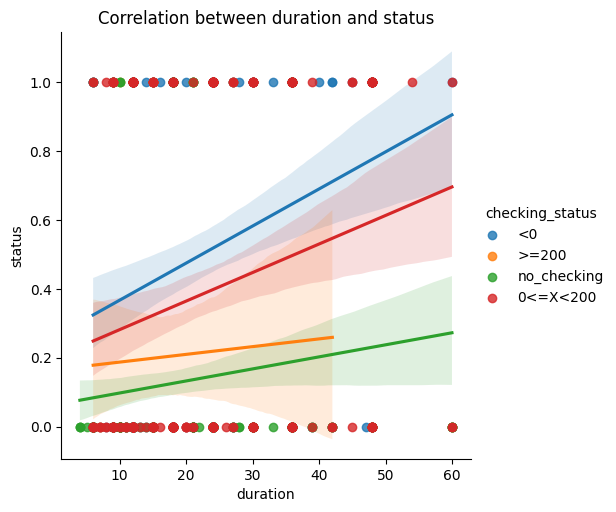

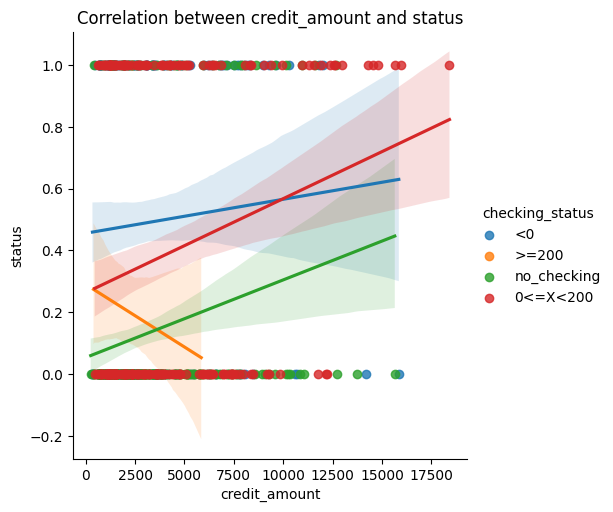

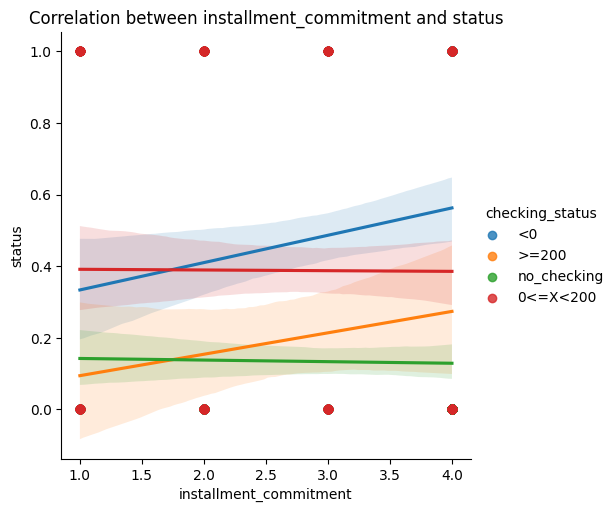

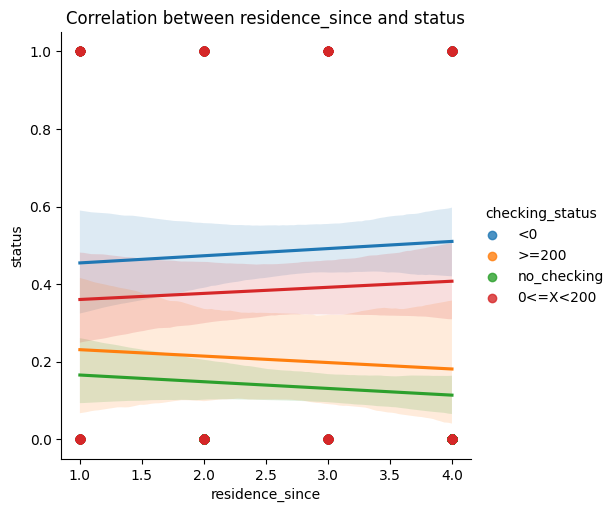

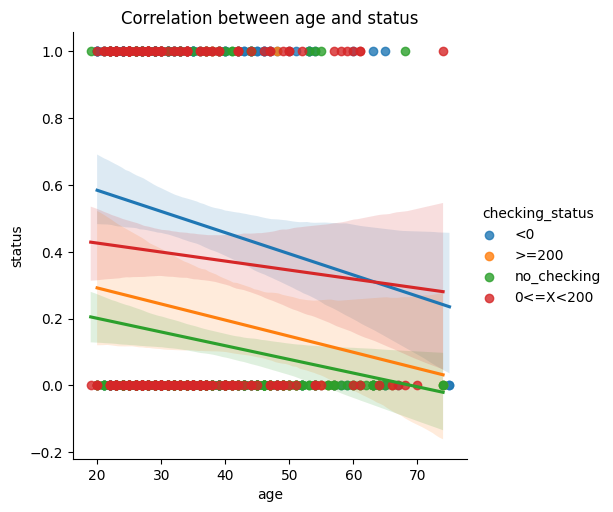

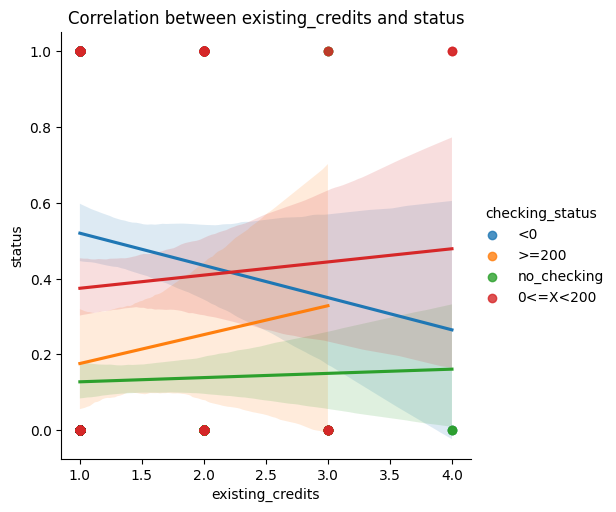

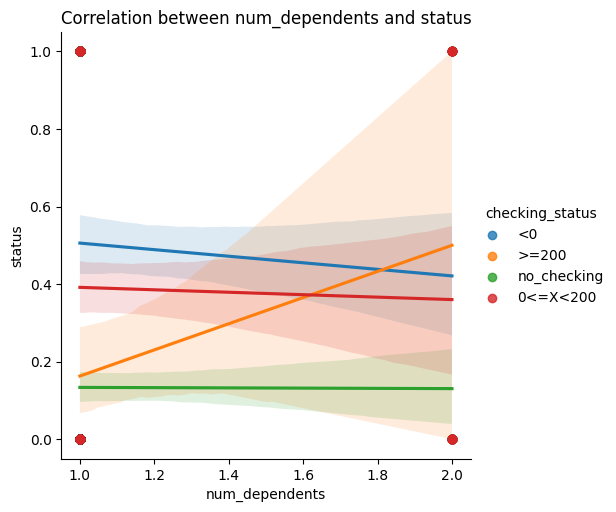

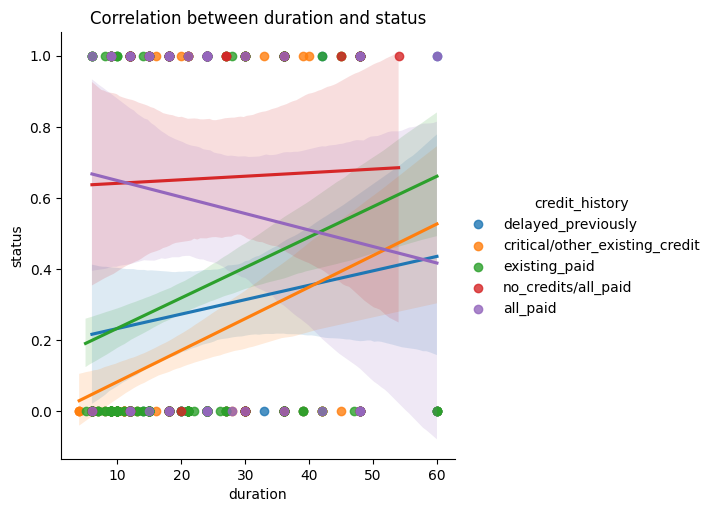

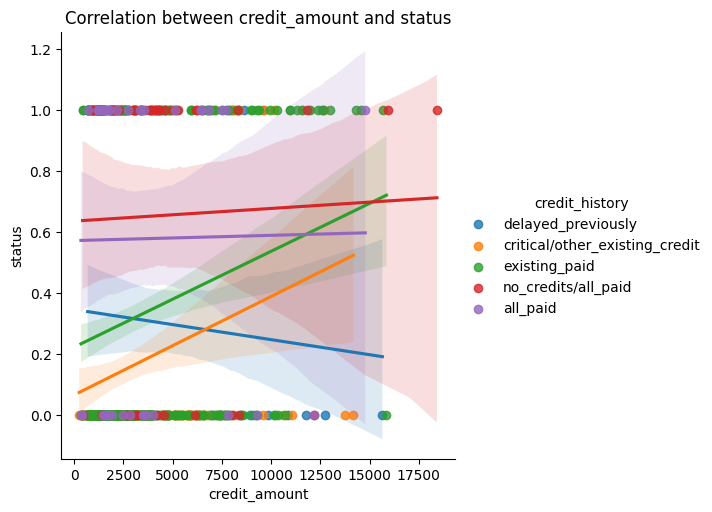

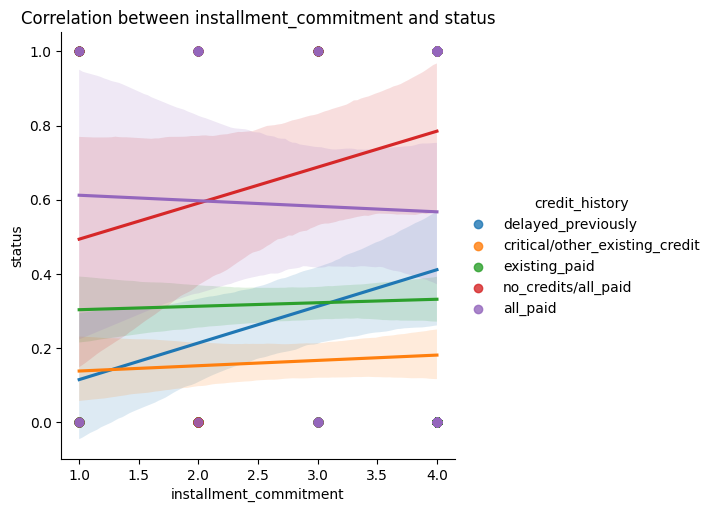

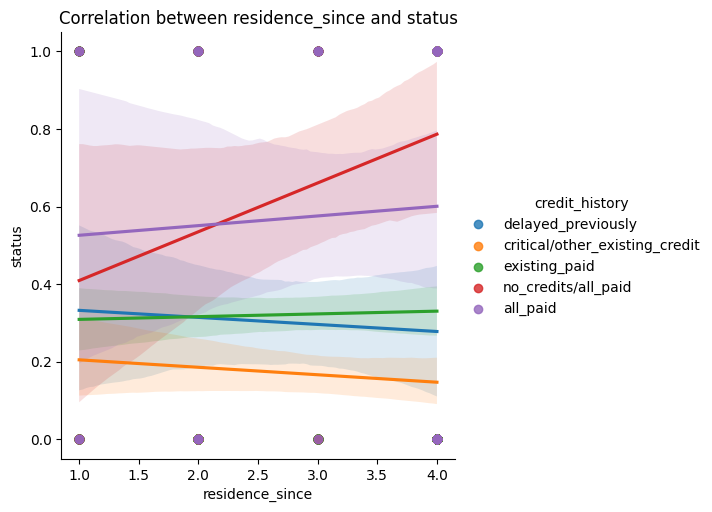

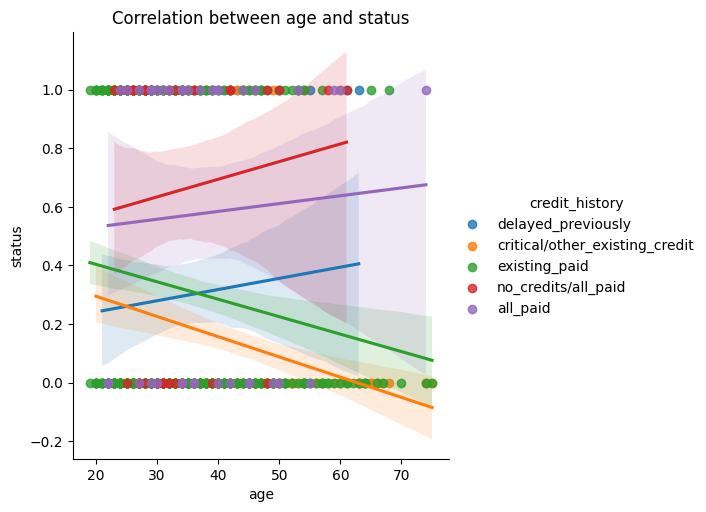

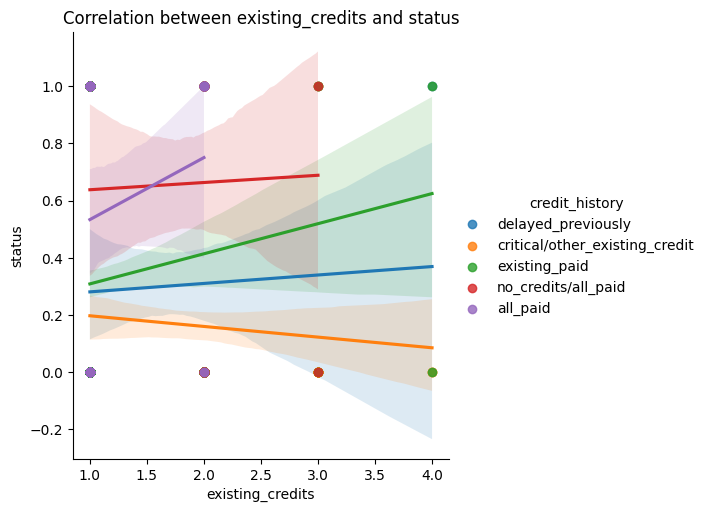

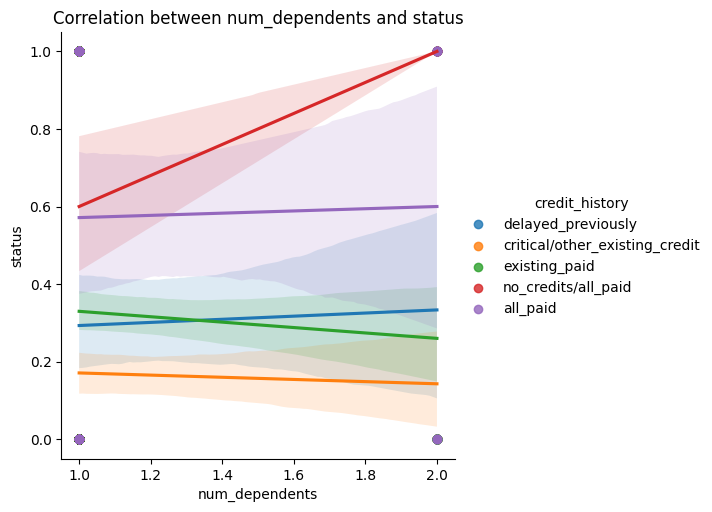

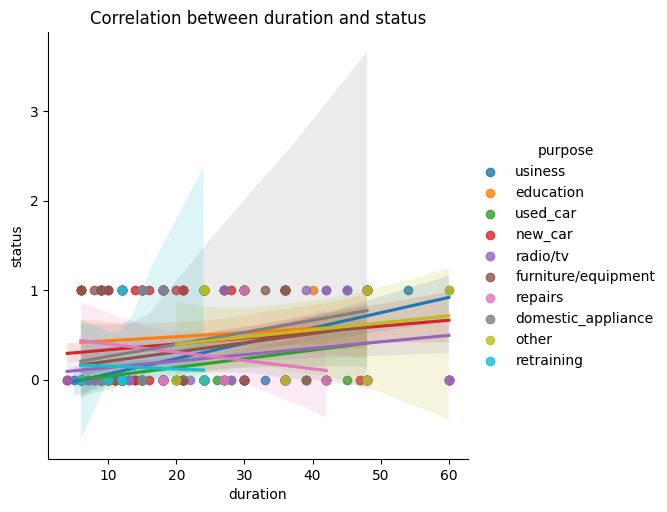

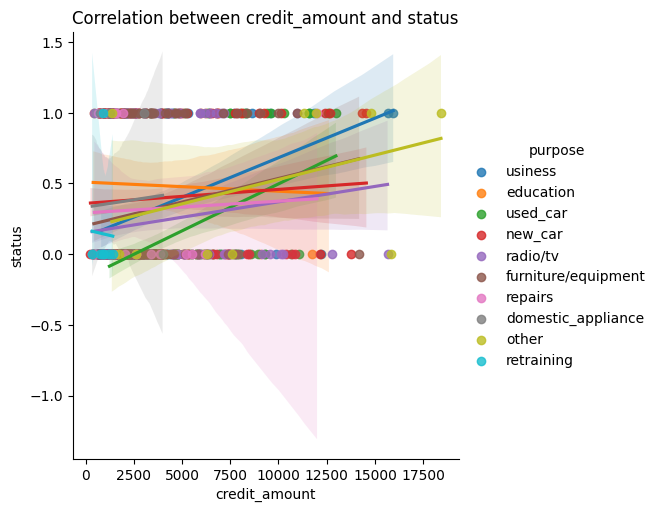

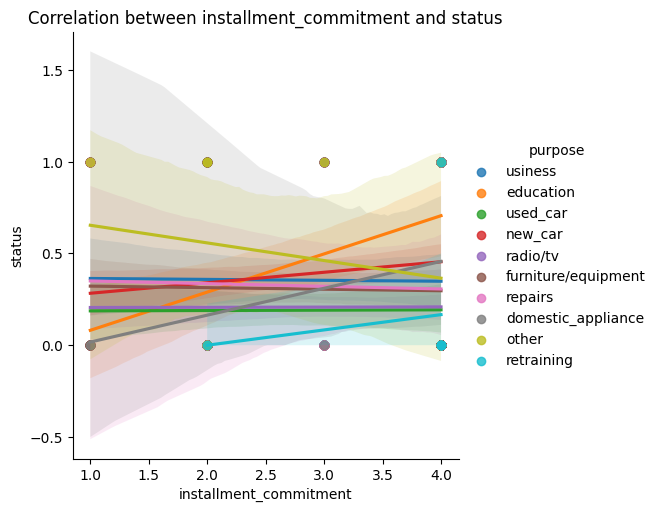

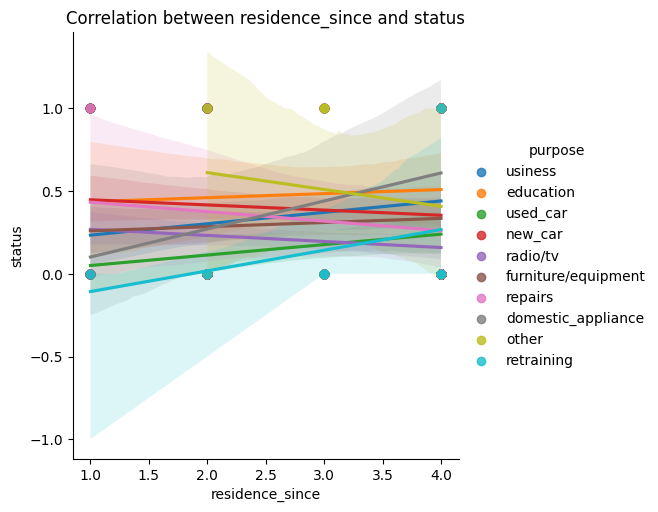

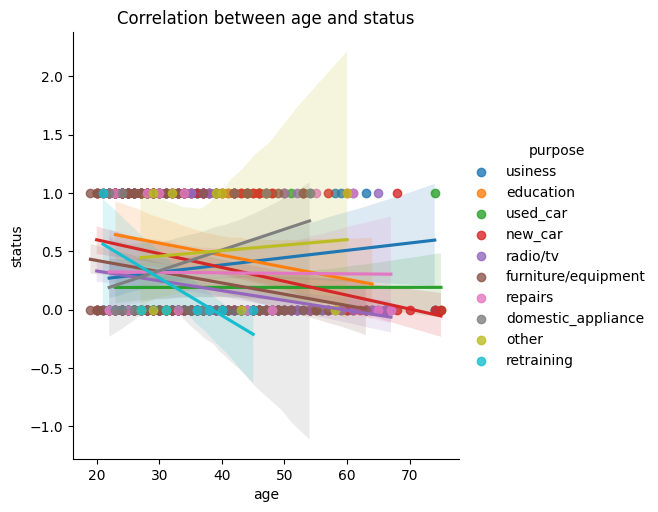

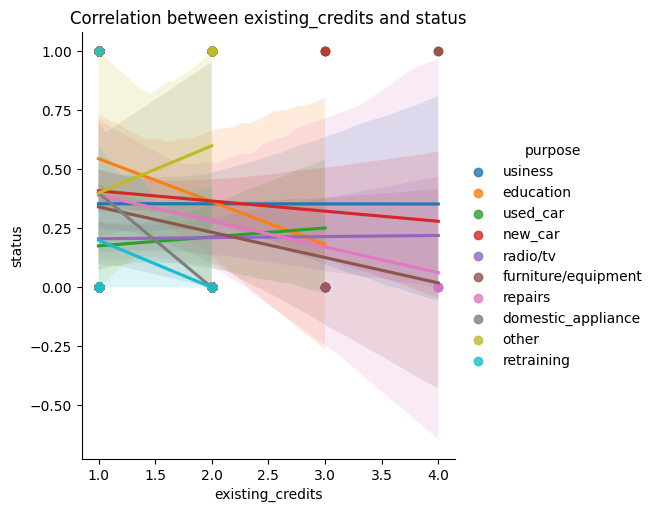

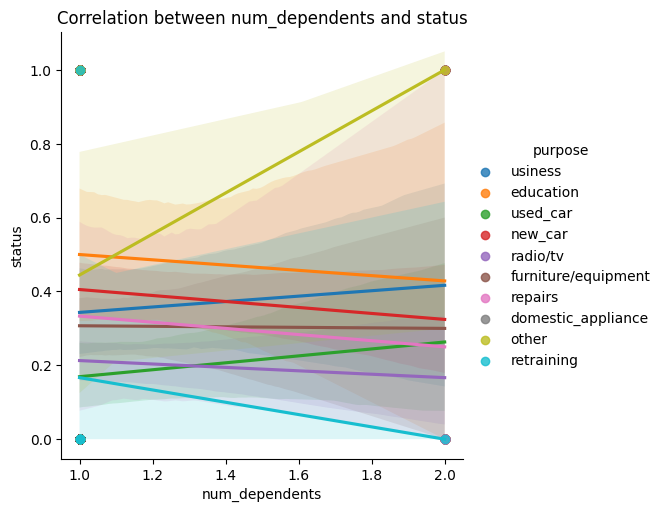

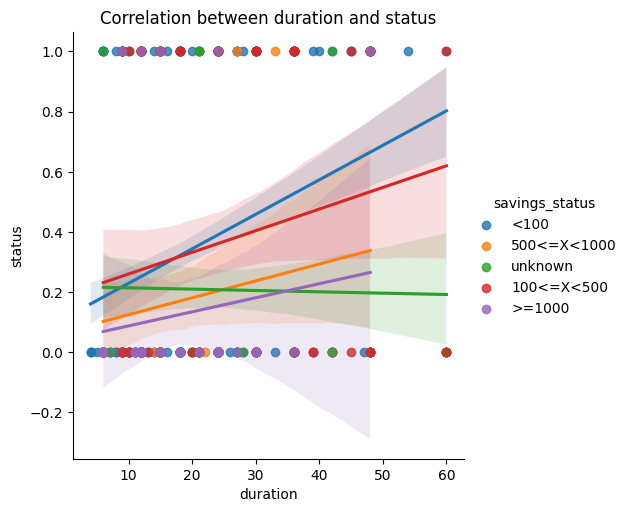

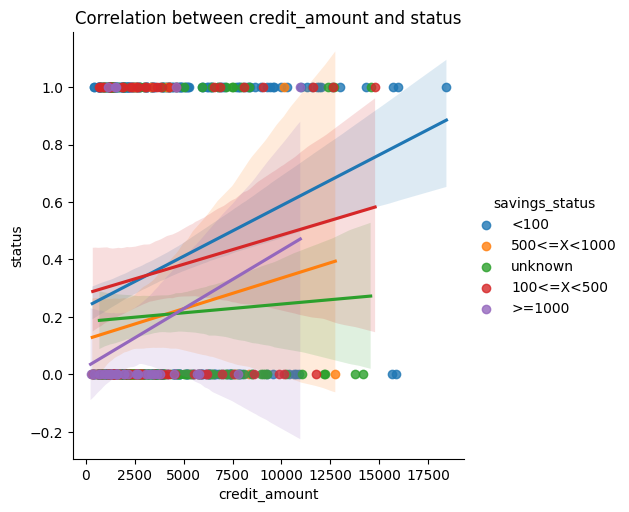

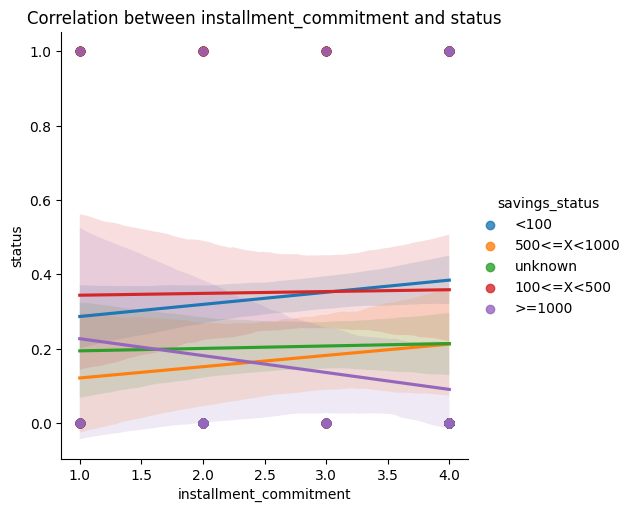

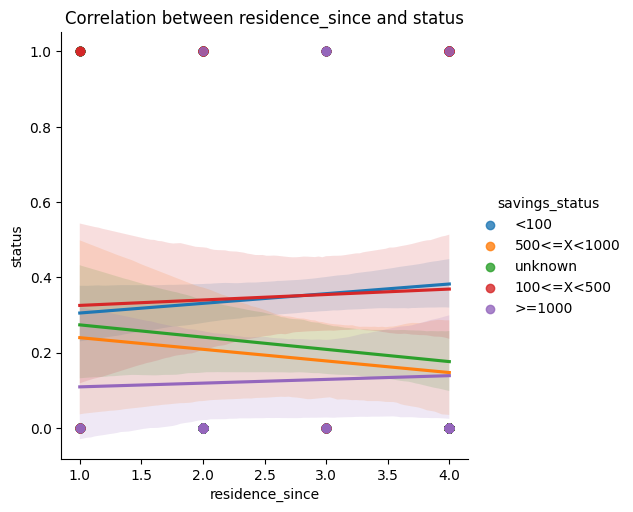

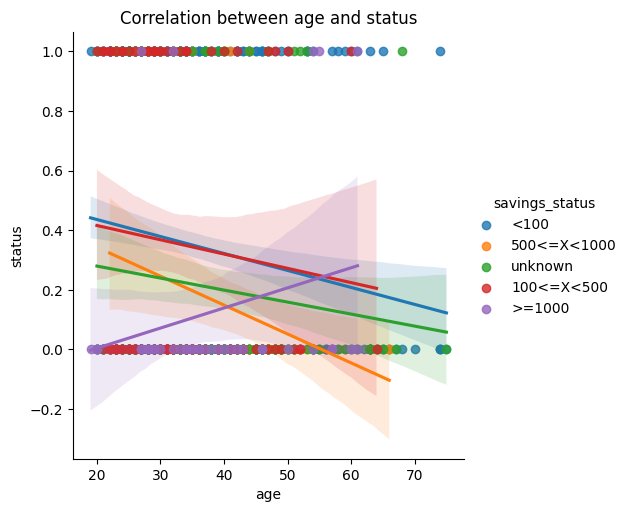

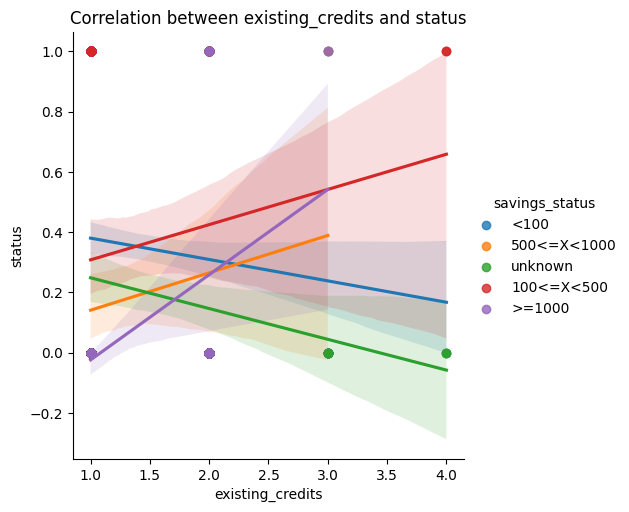

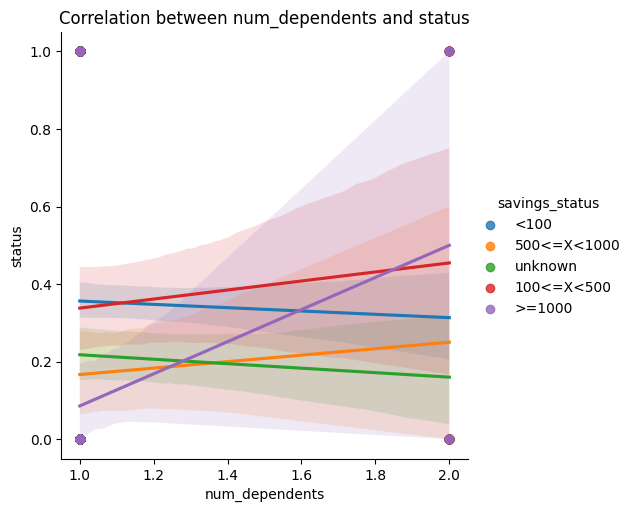

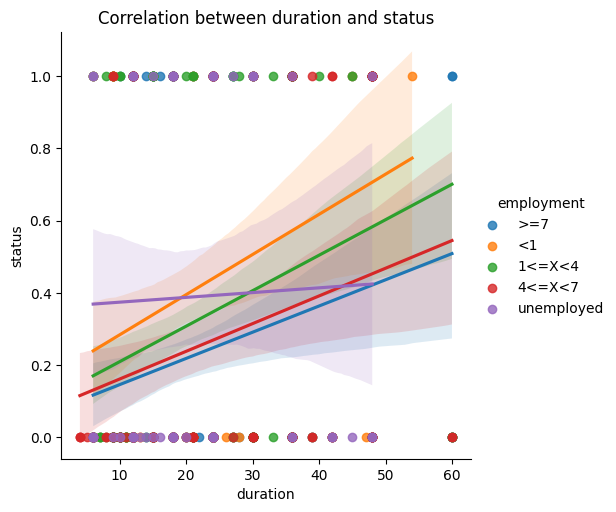

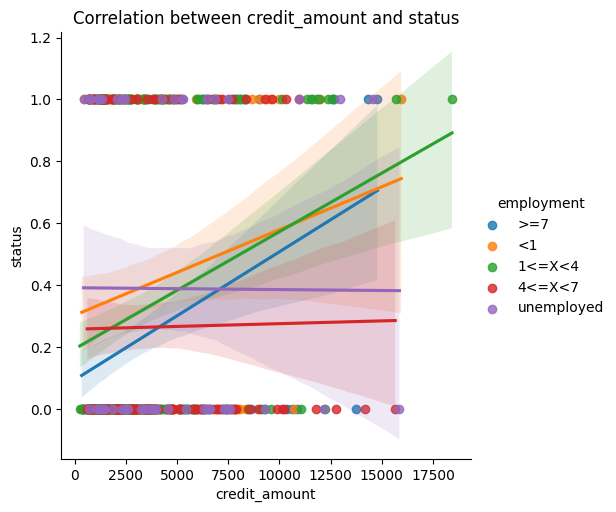

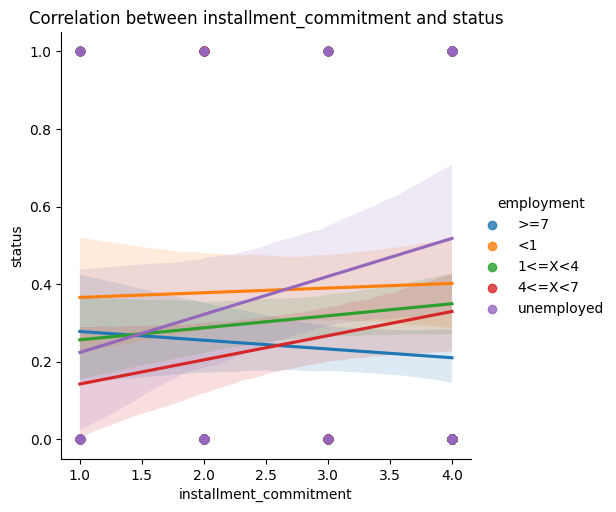

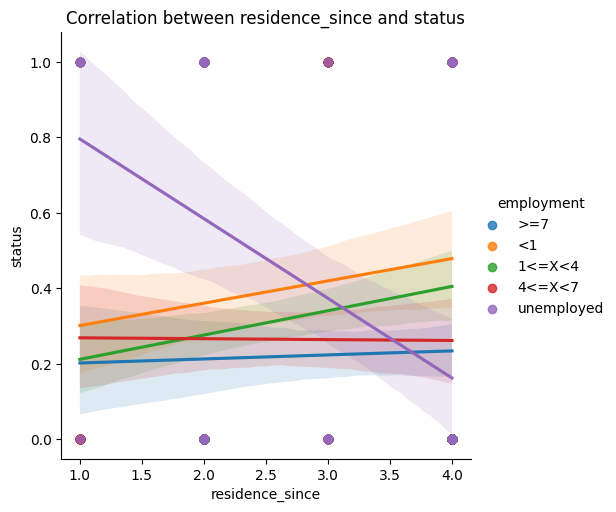

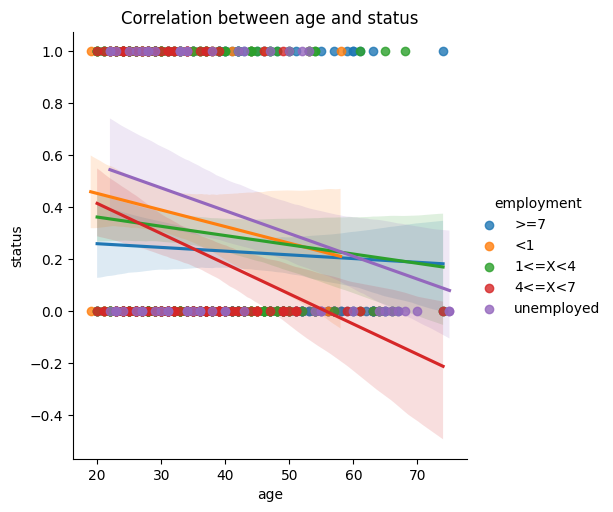

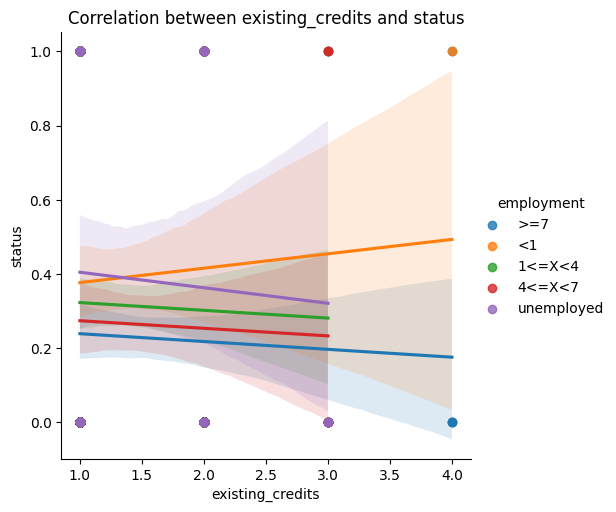

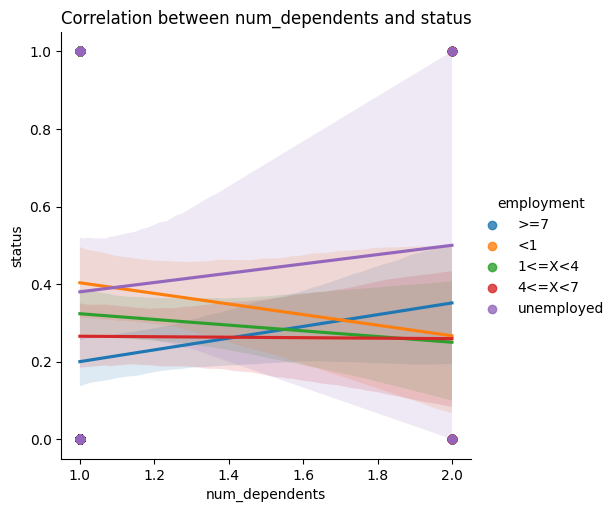

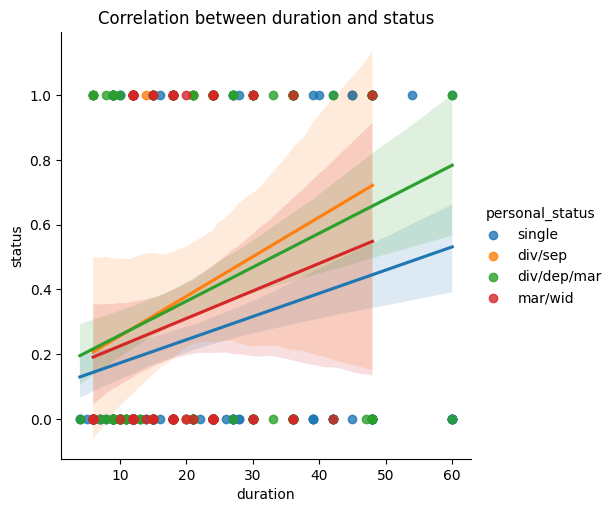

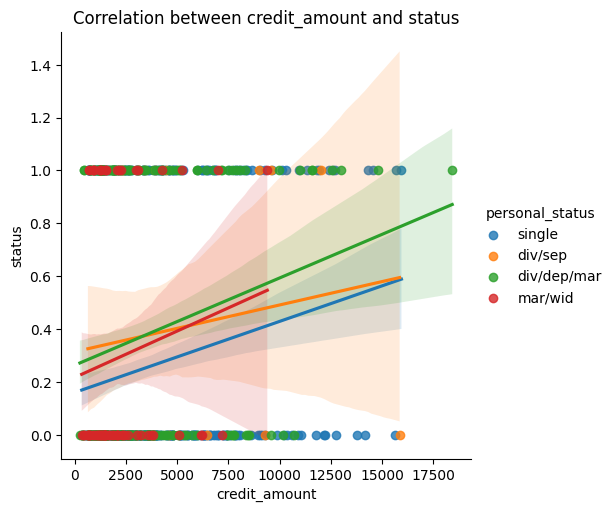

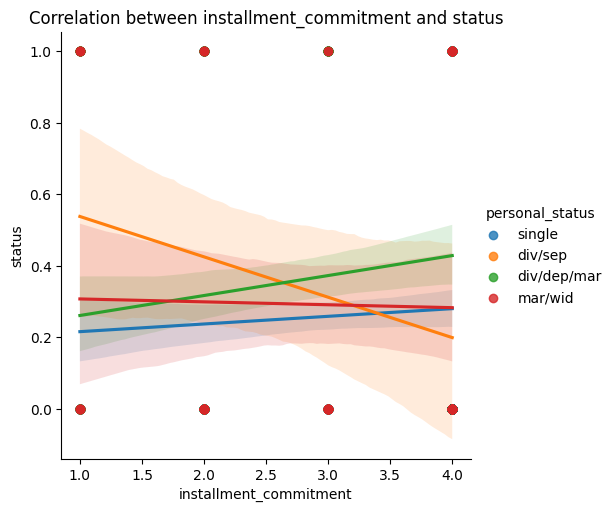

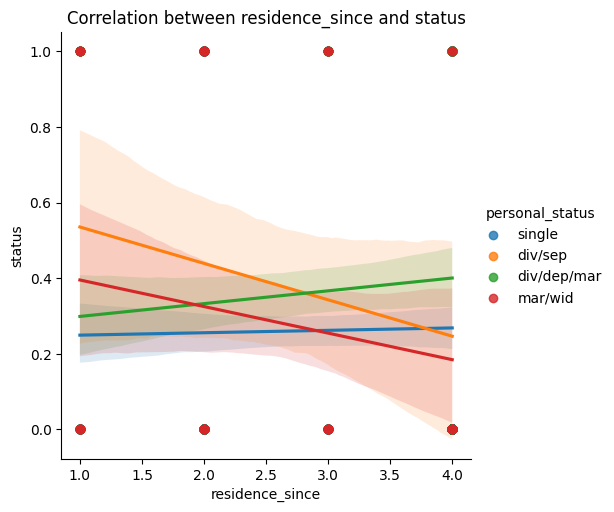

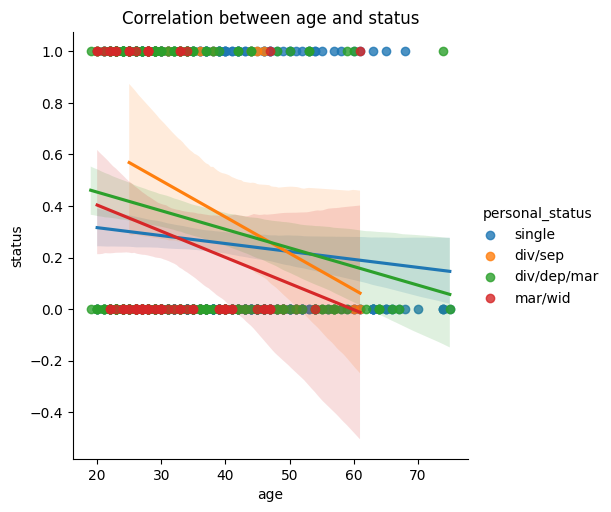

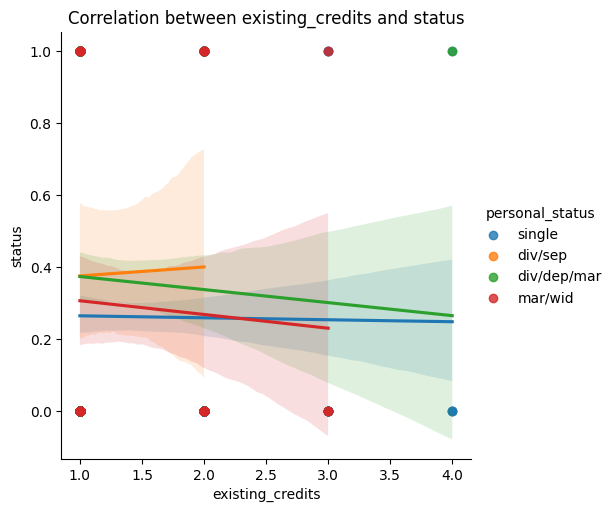

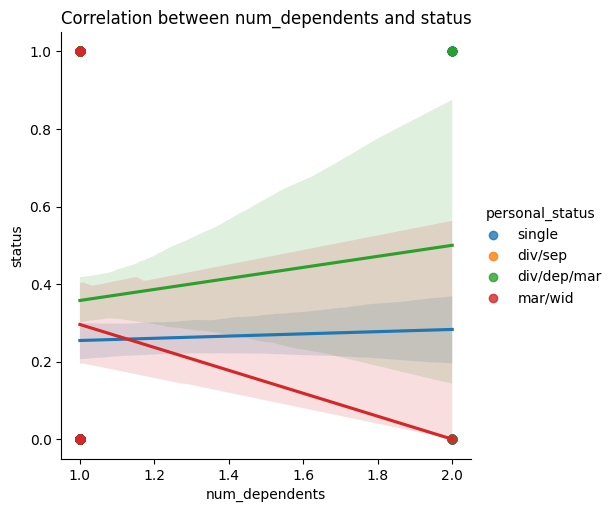

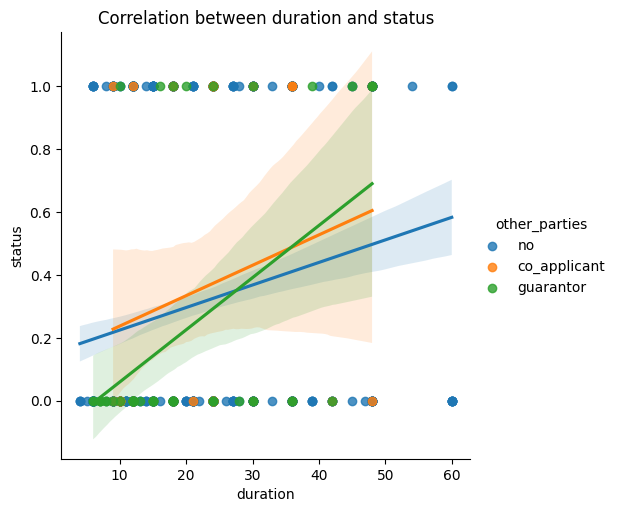

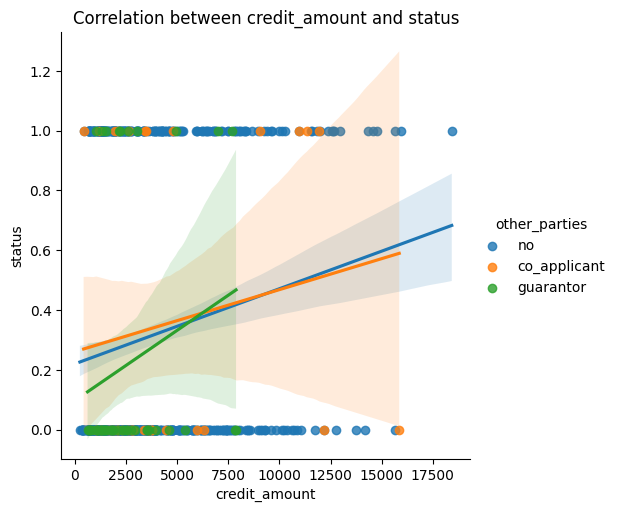

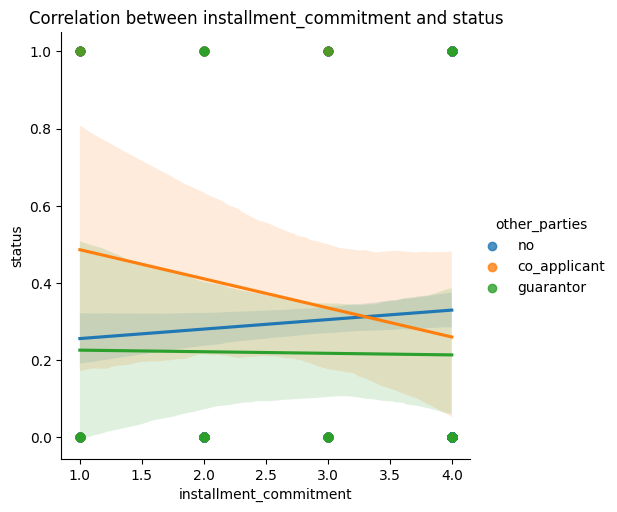

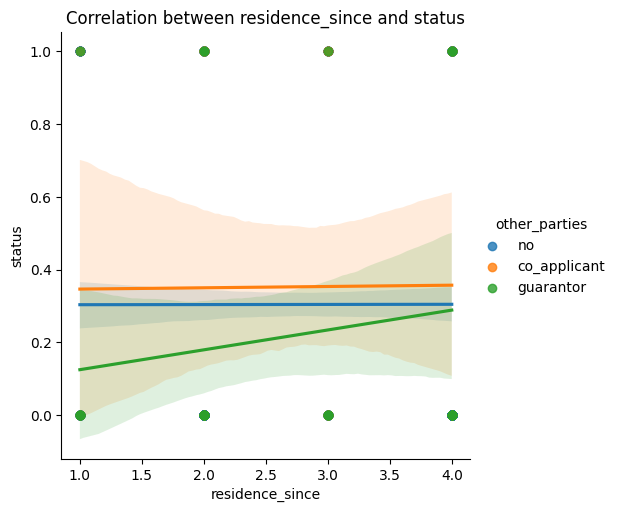

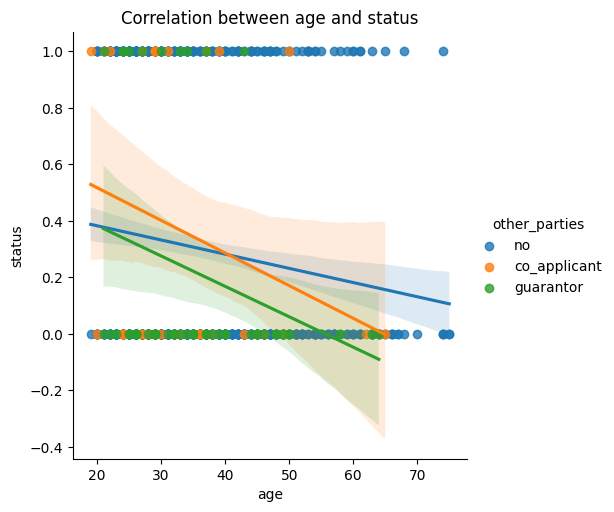

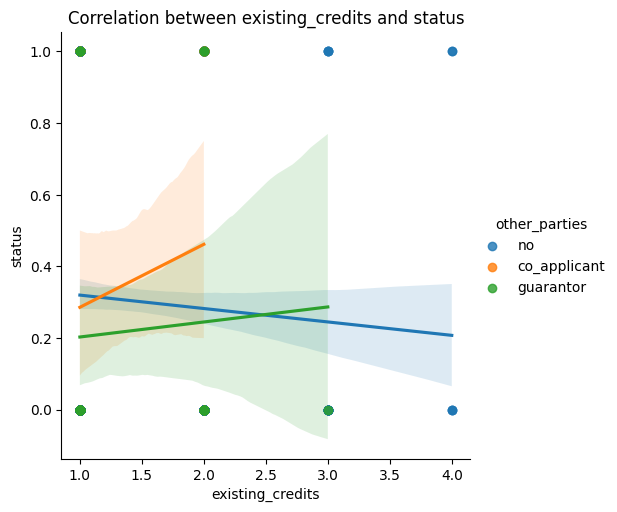

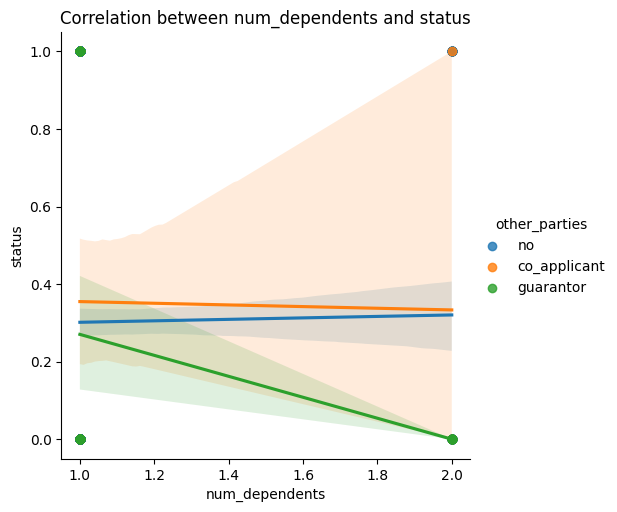

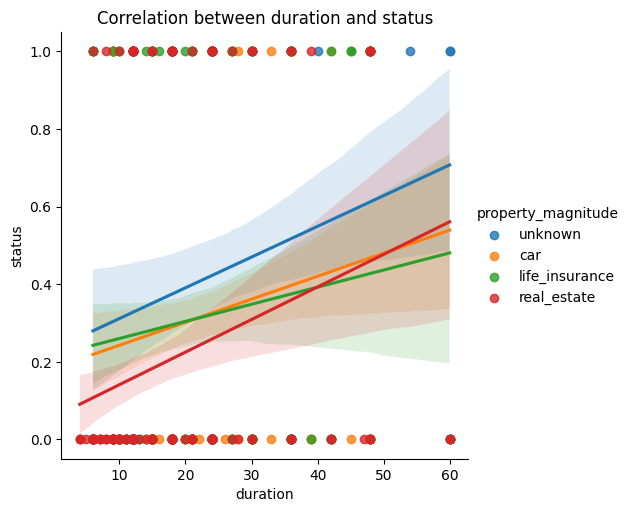

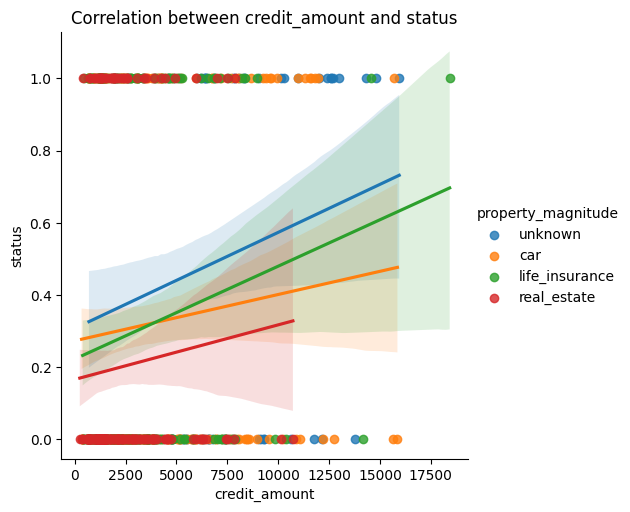

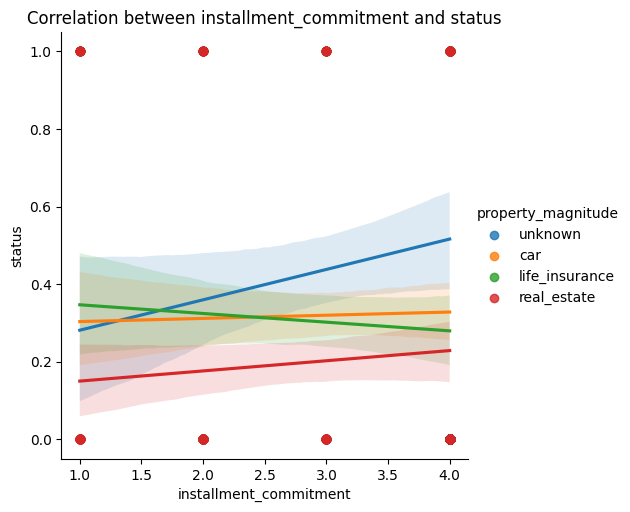

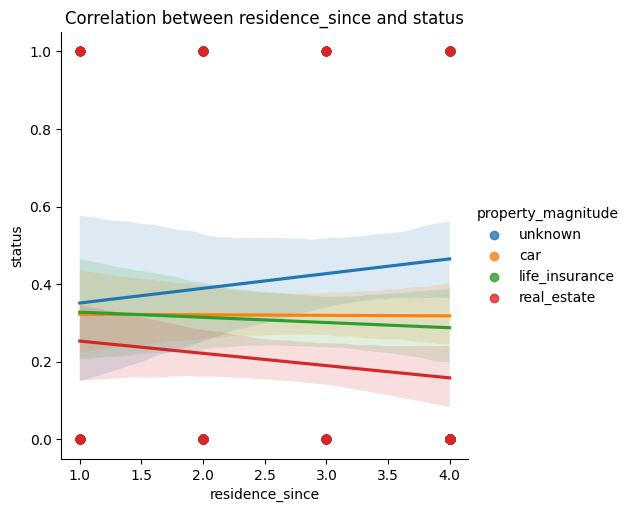

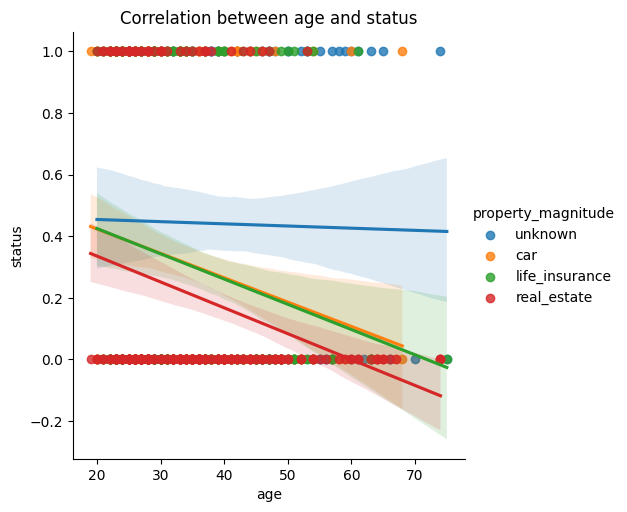

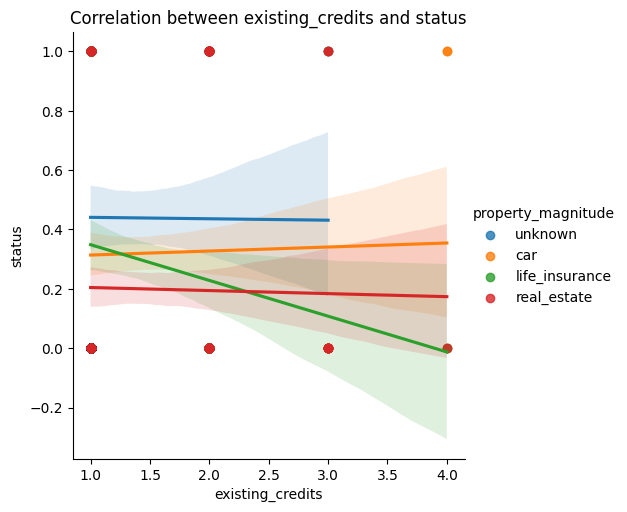

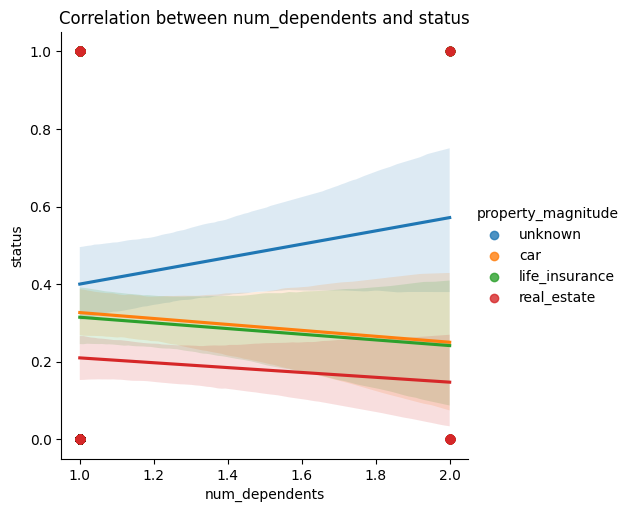

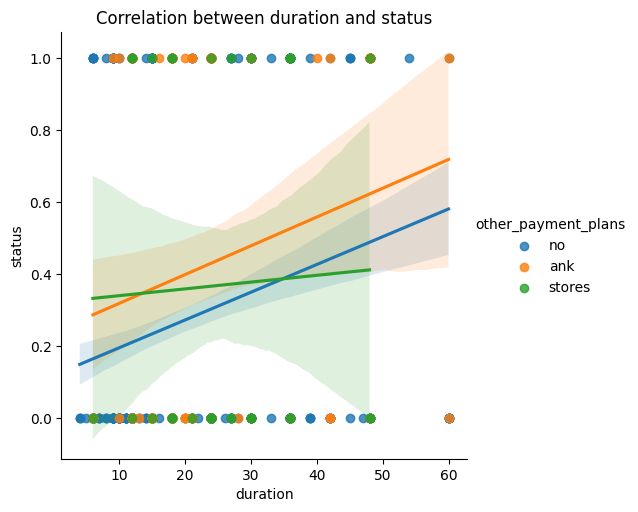

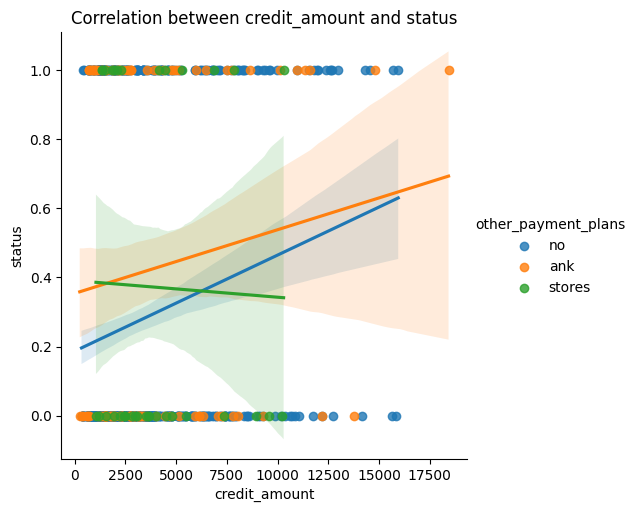

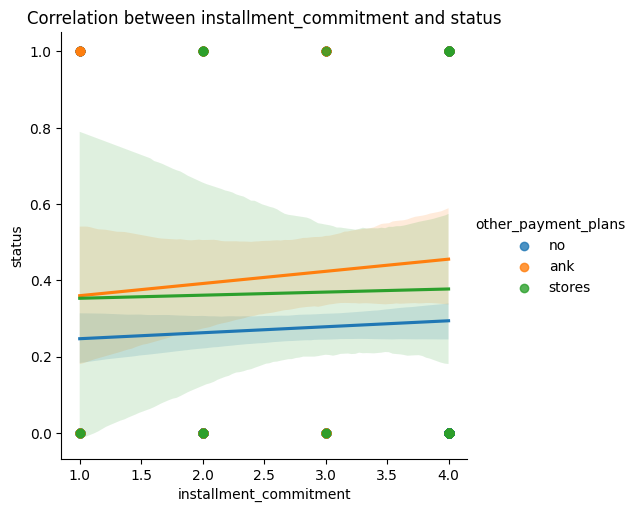

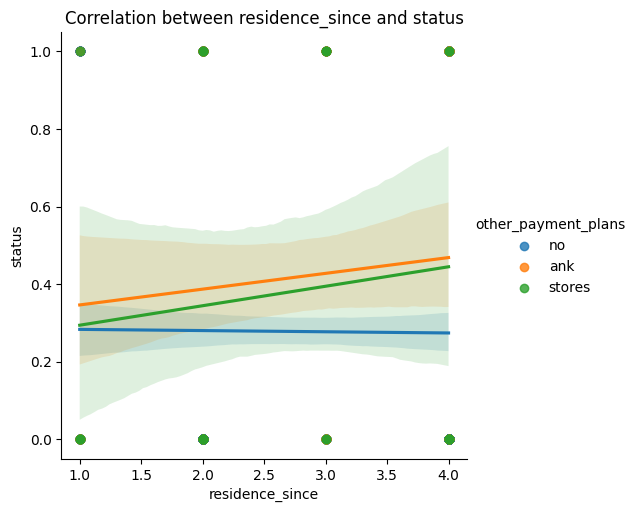

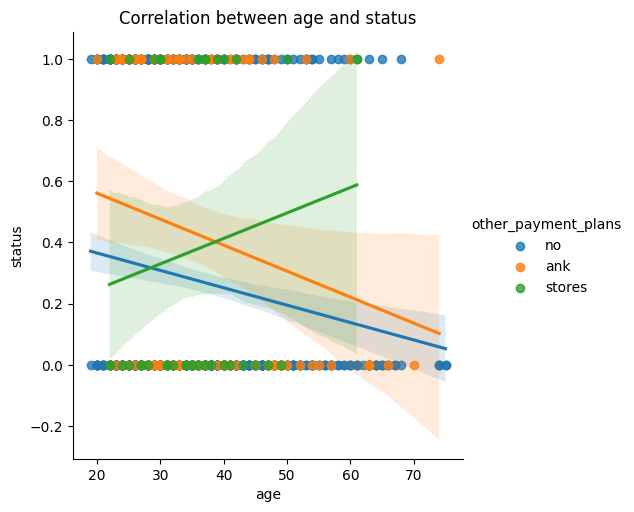

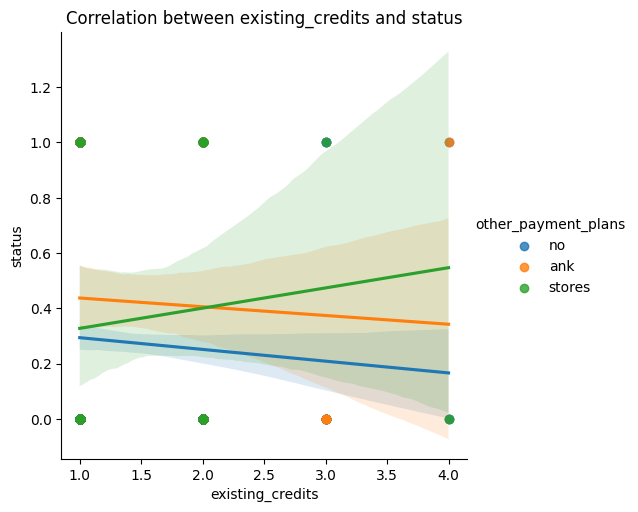

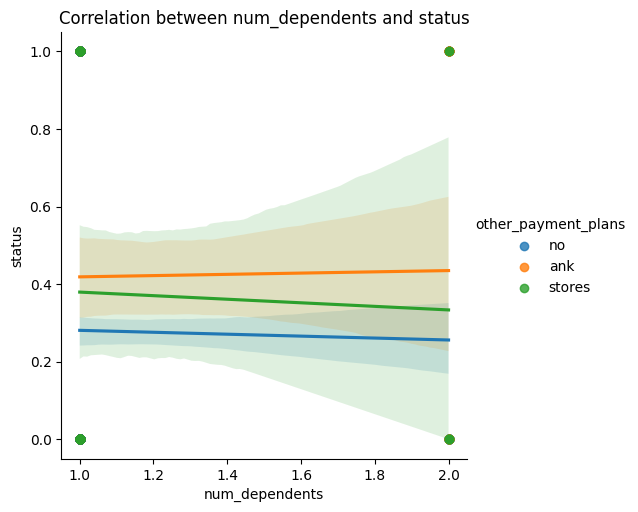

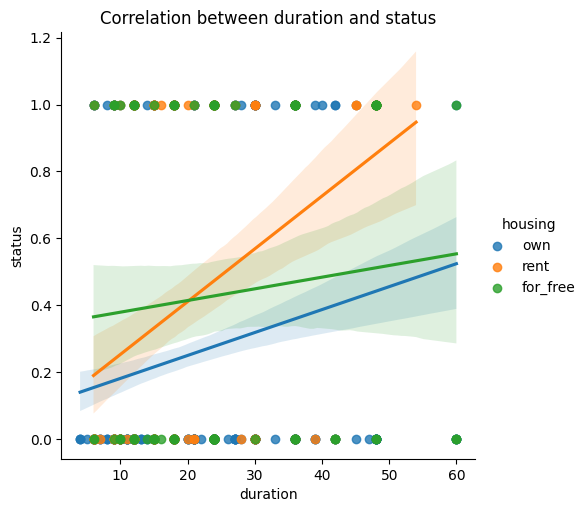

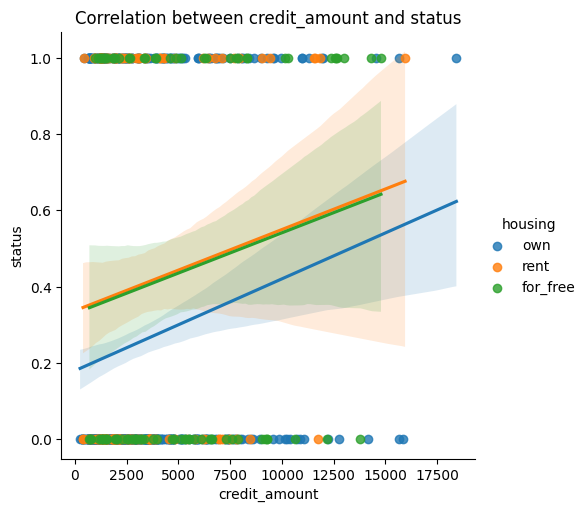

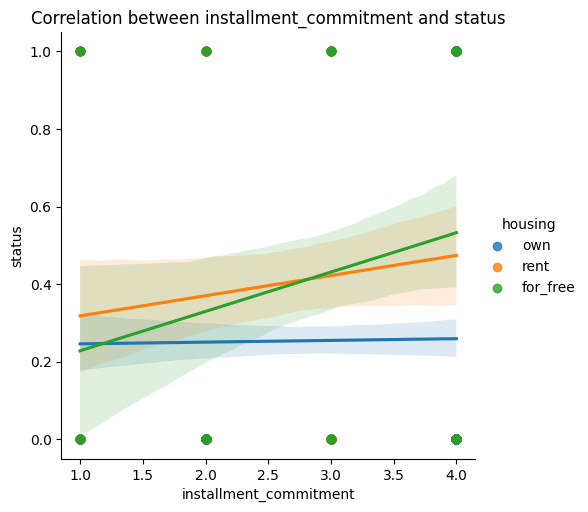

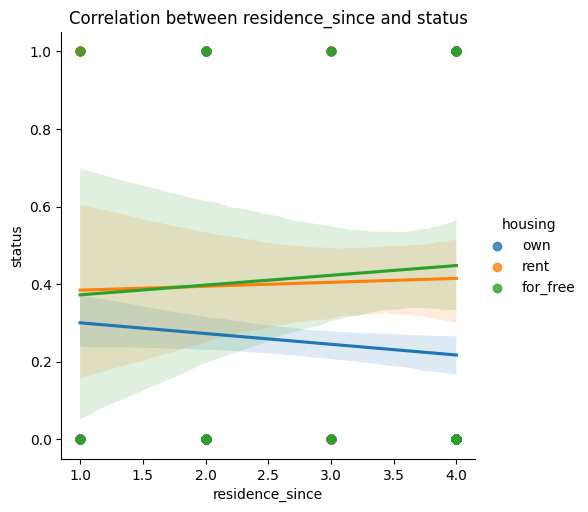

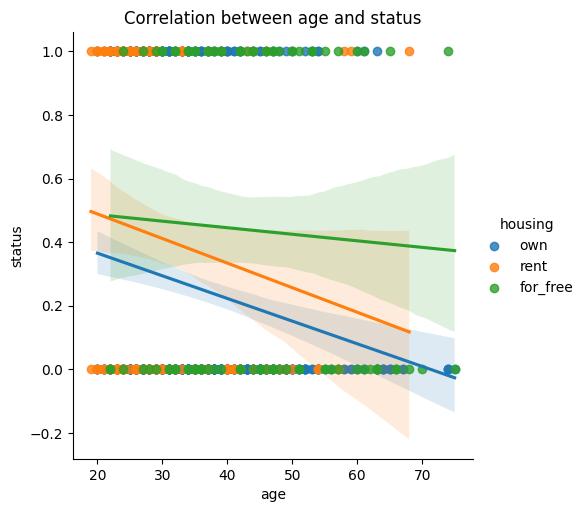

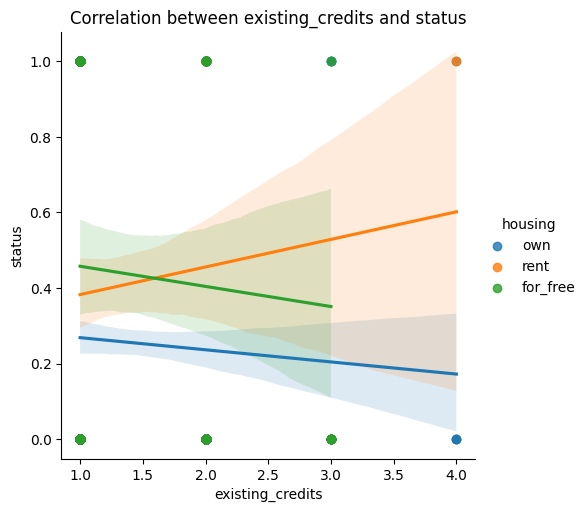

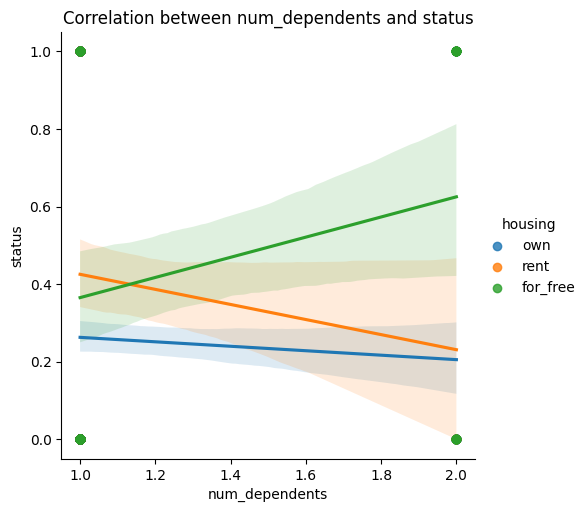

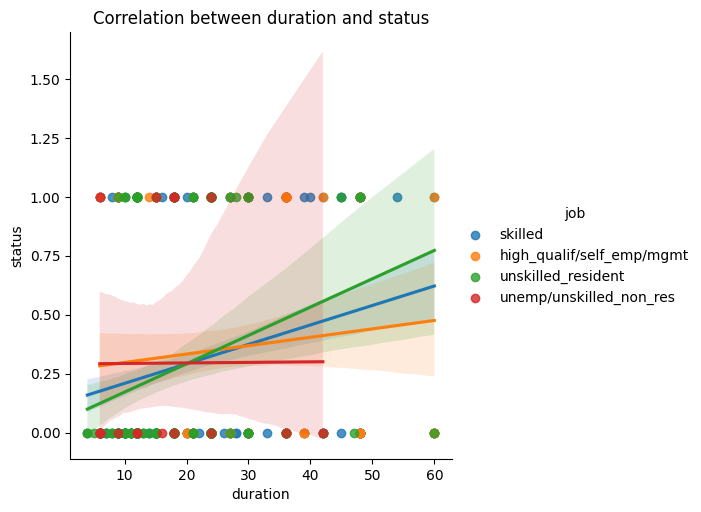

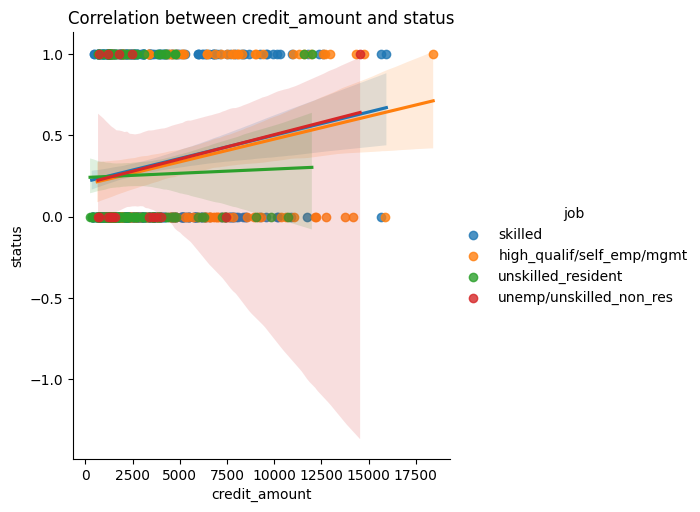

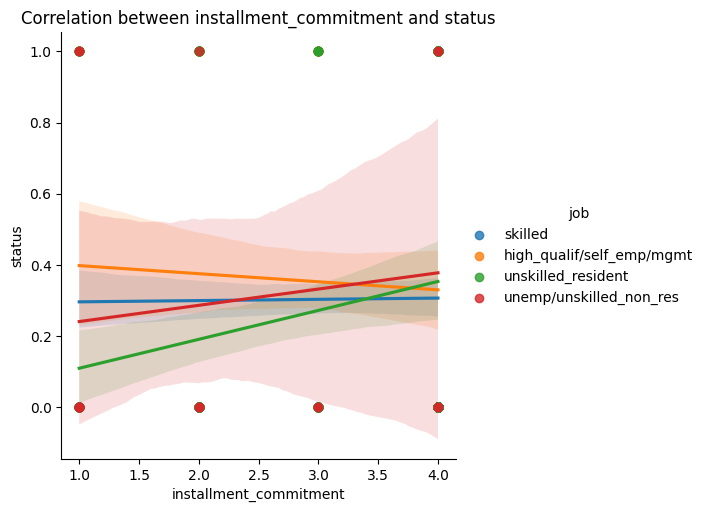

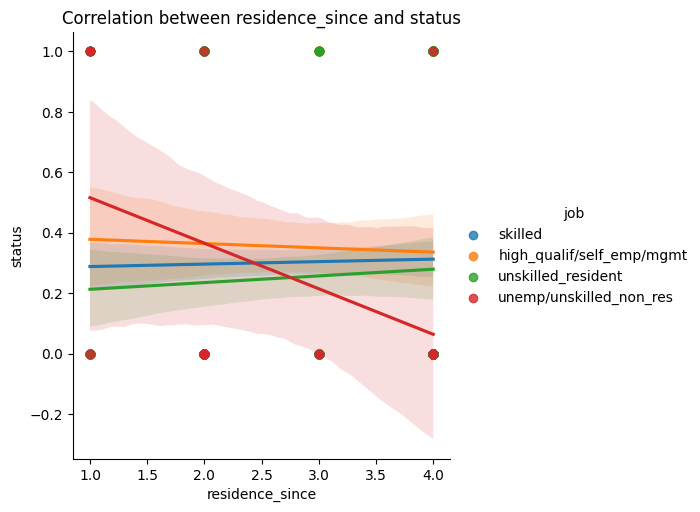

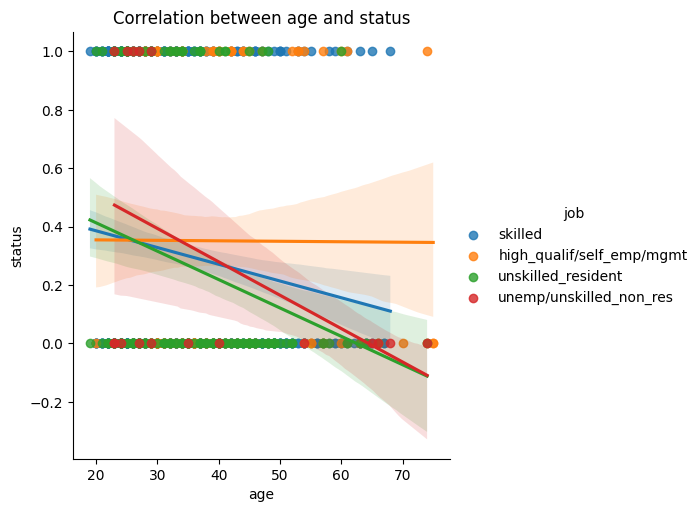

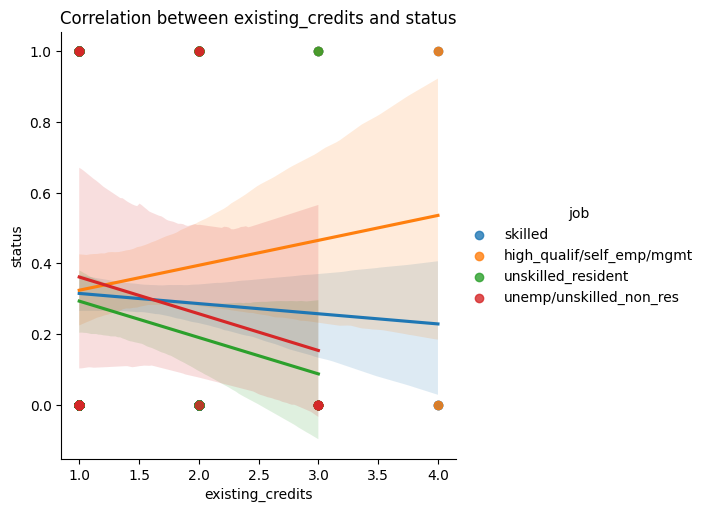

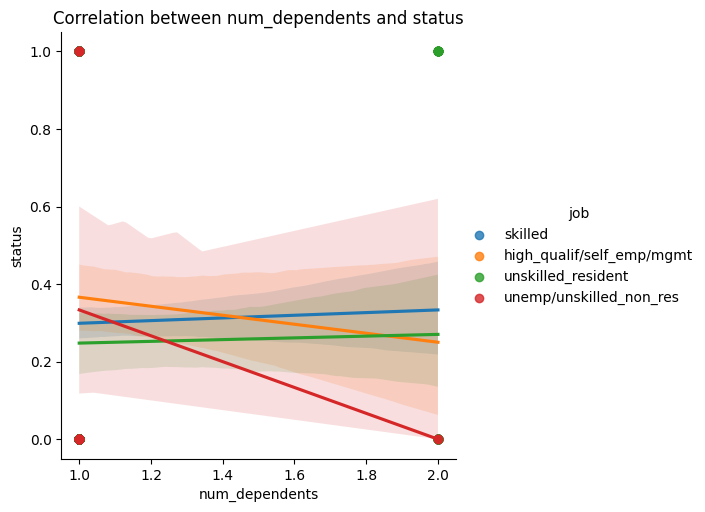

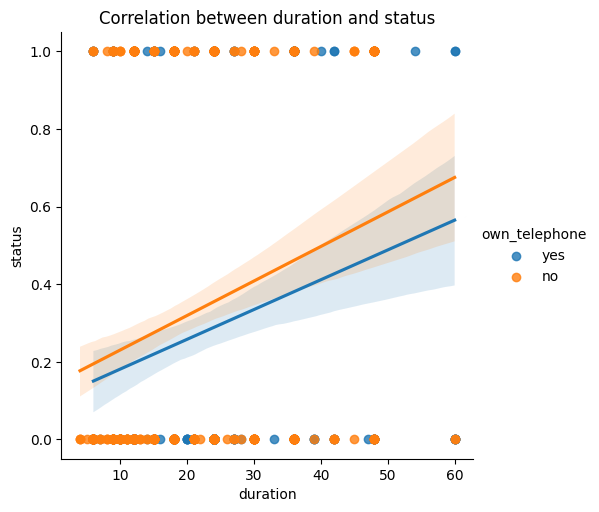

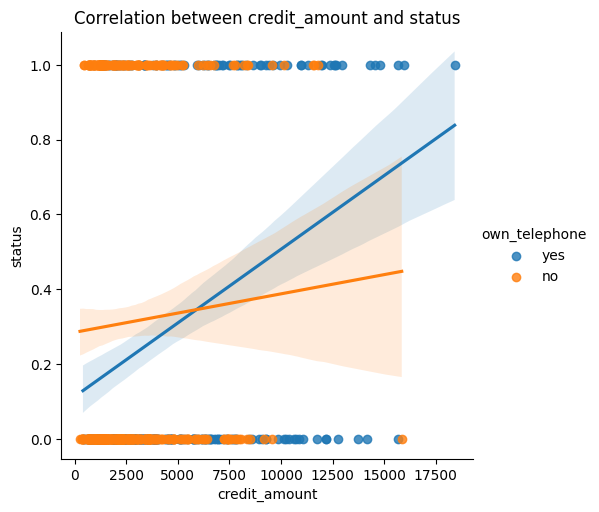

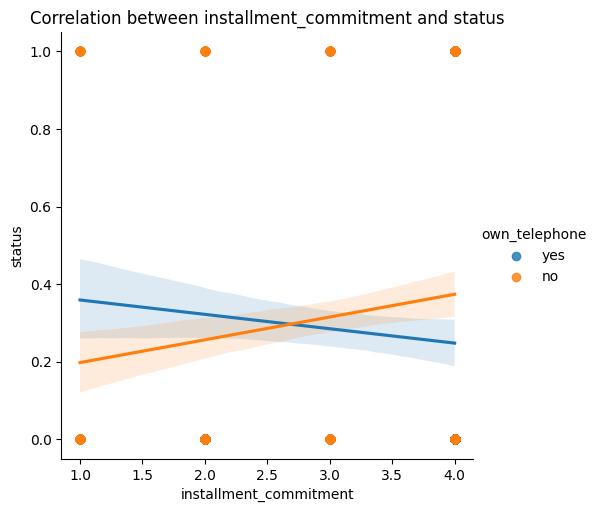

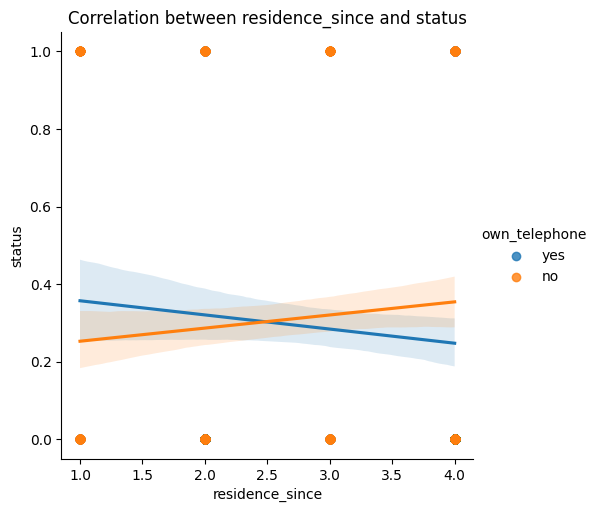

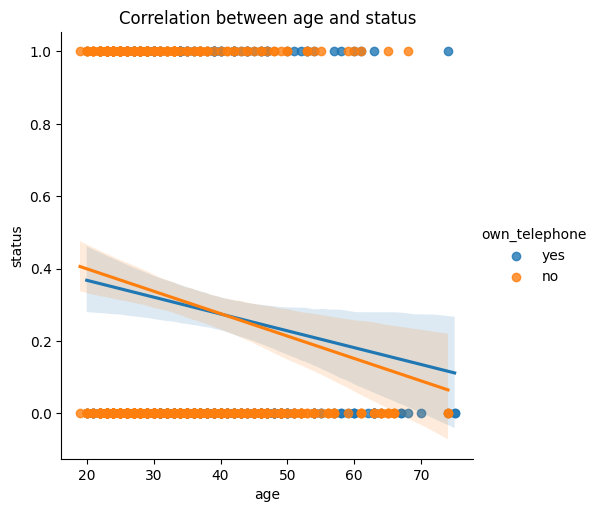

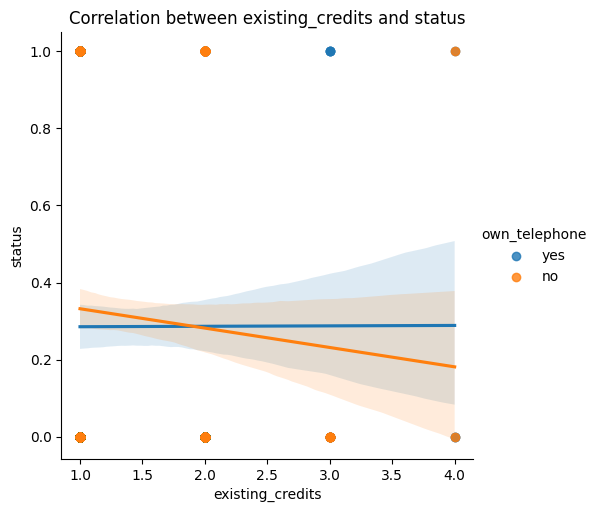

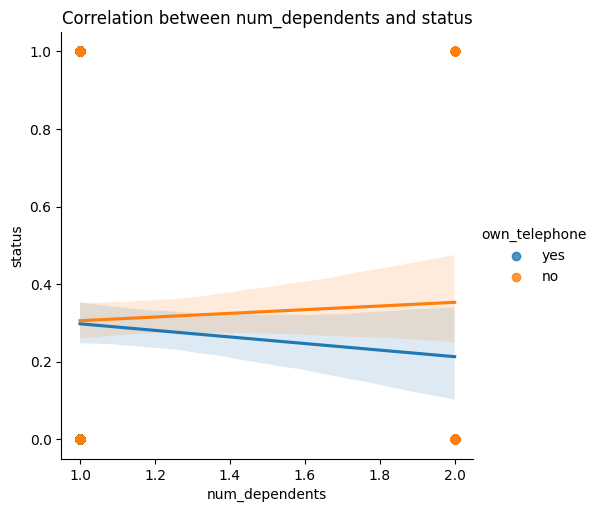

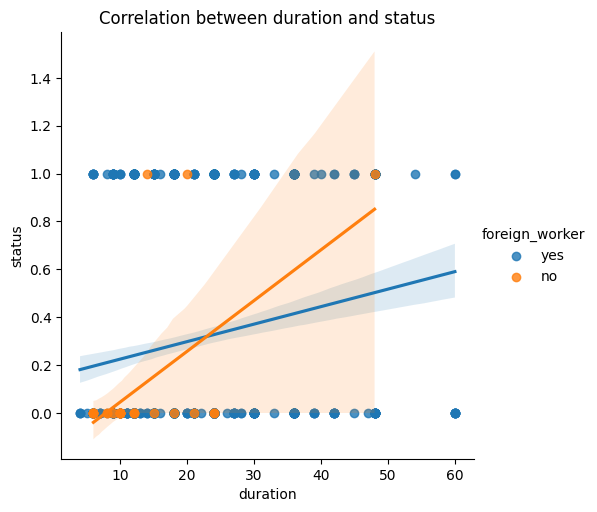

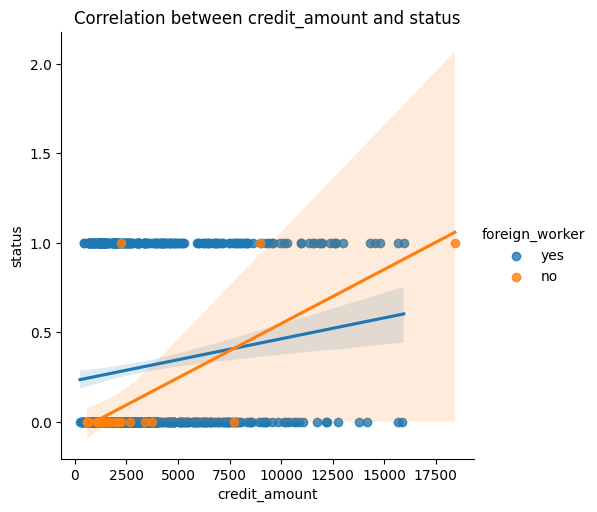

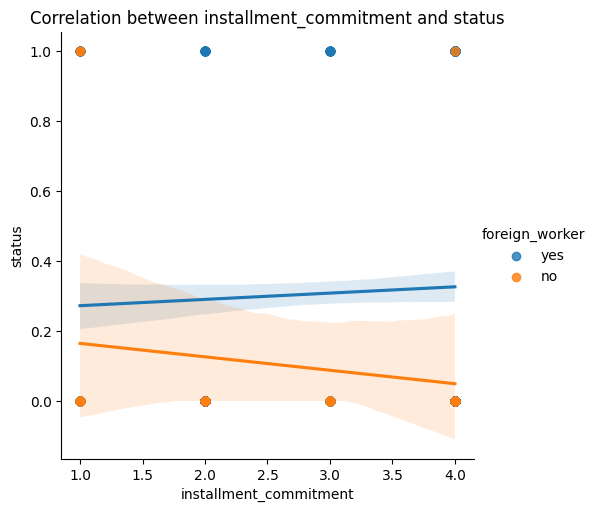

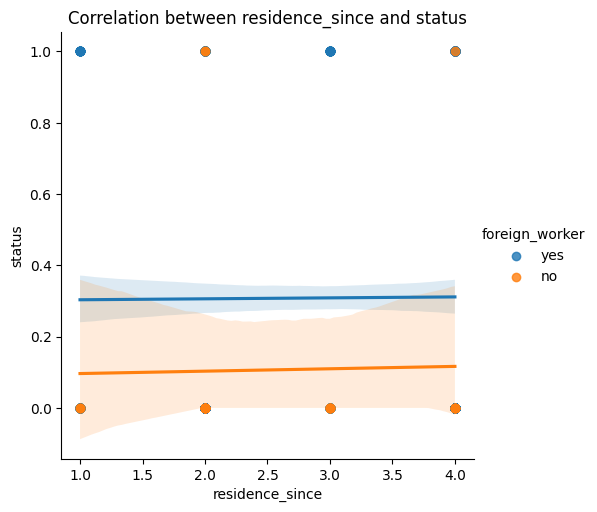

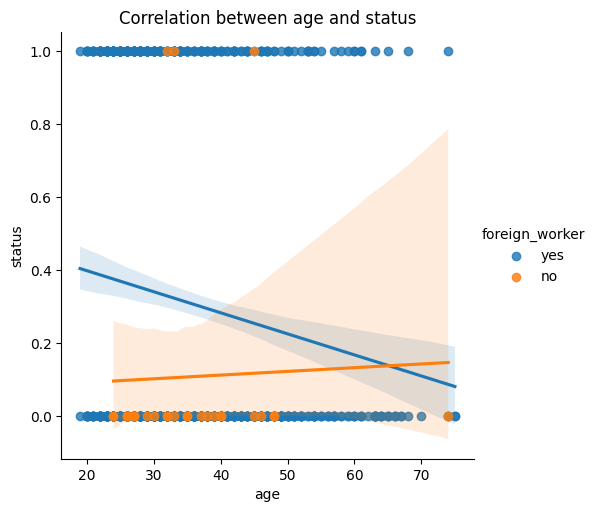

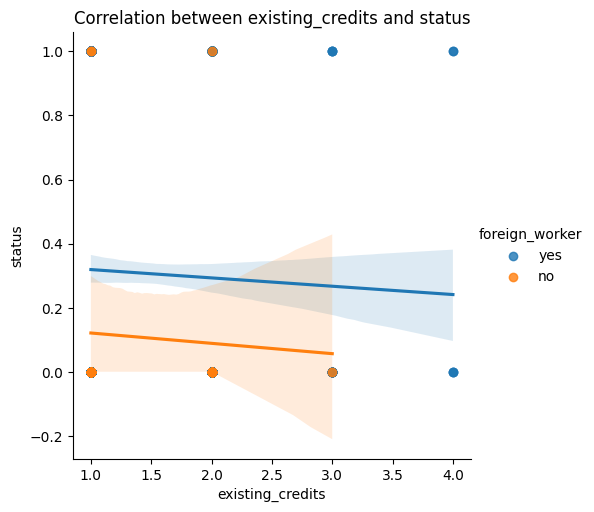

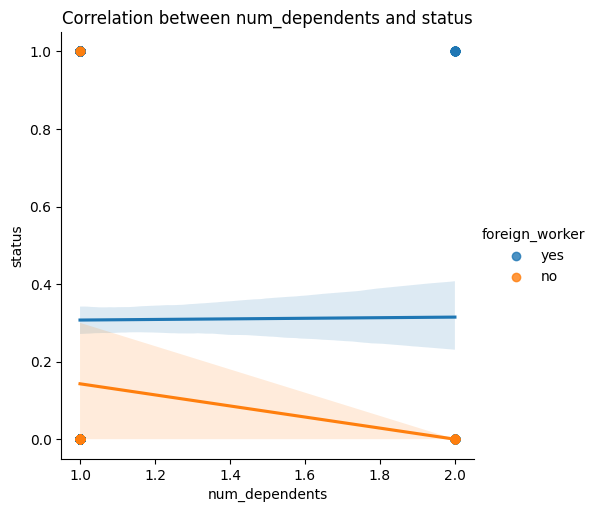

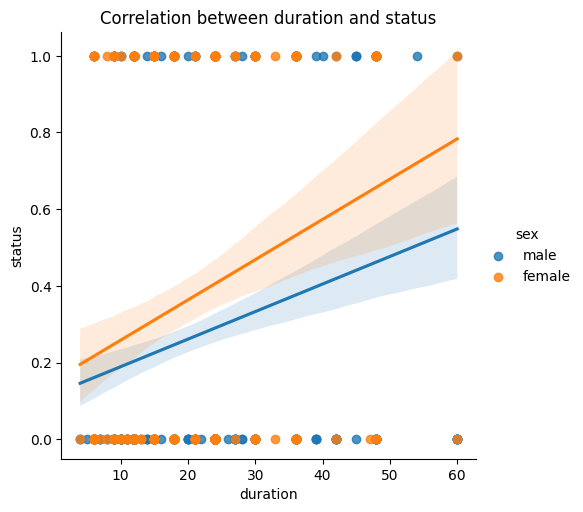

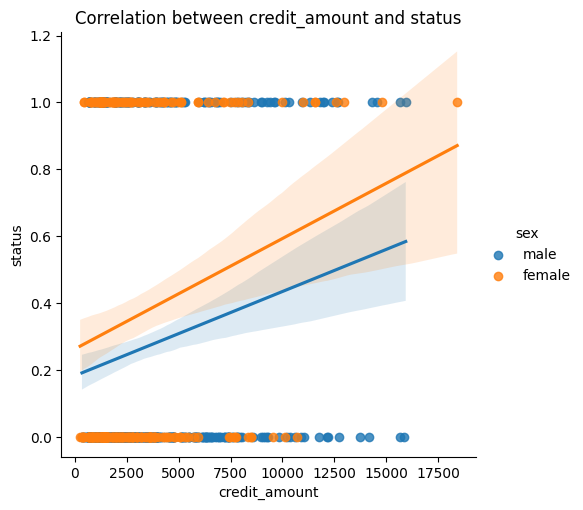

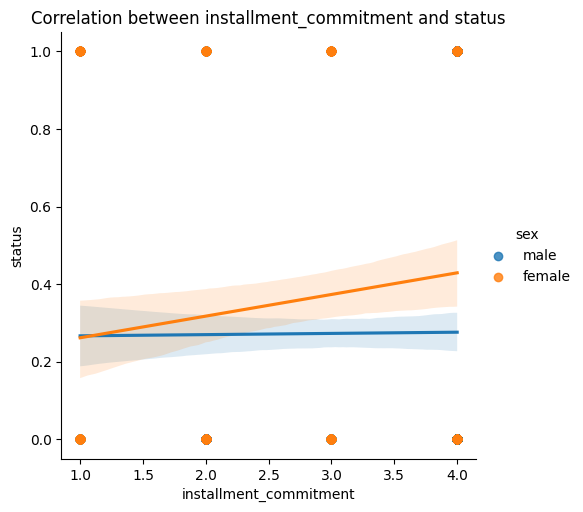

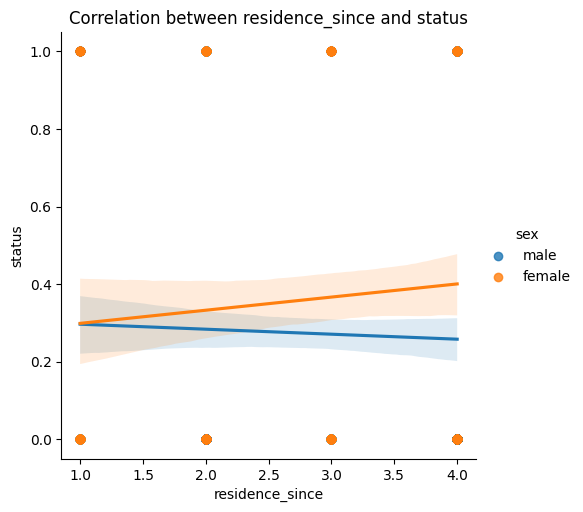

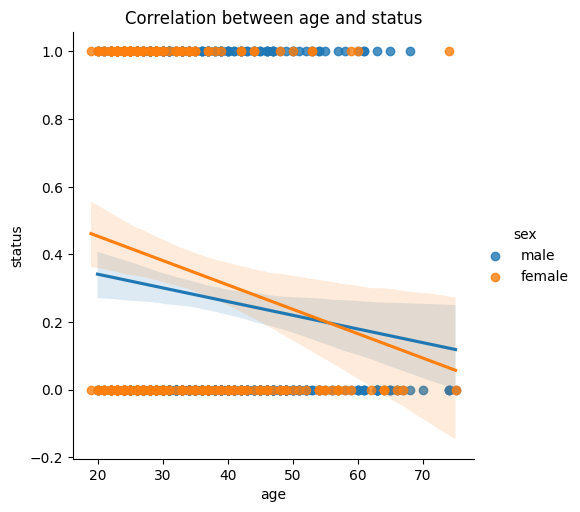

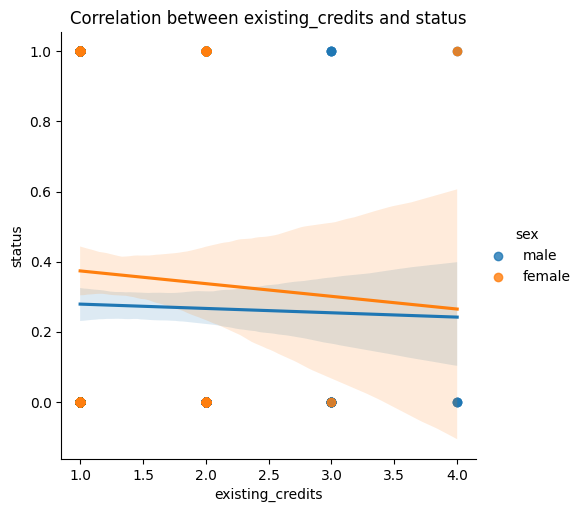

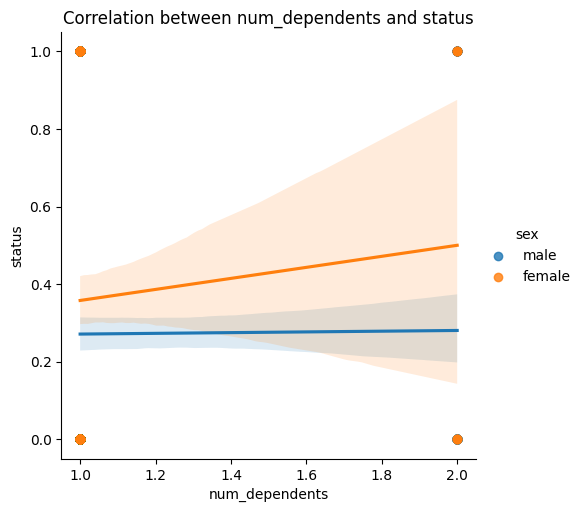

In [256]:
# Scatter plot adding best fit line
for cat_col in categorical_cols:
    for num_col in numeric_cols:
        sns.lmplot(x=num_col, y="status", data=df_full_train, hue=cat_col)
        ax = plt.gca()
        ax.set_title(f'Correlation between {num_col} and status')

/var/folders/sg/wwnw3qcd7qq0g31bxw_dlcvw0000gn/T/ipykernel_42074/3201736003.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr = df_full_train.corr()


duration  credit_amount  installment_commitment  \
duration                    1.00           0.63                    0.04   
credit_amount               0.63           1.00                   -0.29   
installment_commitment      0.04          -0.29                    1.00   
residence_since             0.05           0.04                    0.03   
age                        -0.05           0.03                    0.03   
existing_credits           -0.01           0.02                    0.01   
num_dependents             -0.01           0.04                   -0.07   
status                      0.20           0.16                    0.04   

                        residence_since   age  existing_credits  \
duration                           0.05 -0.05             -0.01   
credit_amount                      0.04  0.03              0.02   
installment_commitment             0.03  0.03              0.01   
residence_since                    1.00  0.28              0.08   
age                                0.28  1.00              0.13   
existing_credits                   0.08  0.13              1.00   
num_dependents                     0.05  0.13              0.12   
status                             0.01 -0.14             -0.03   

                        num_dependents  status  
duration                         -0.01    0.20  
credit_amount                     0.04    0.16  
installment_commitment           -0.07    0.04  
residence_since                   0.05    0.01  
age                               0.13   -0.14  
existing_credits                  0.12   -0.03  
num_dependents                    1.00   -0.00  
status                           -0.00    1.00

<AxesSubplot: >

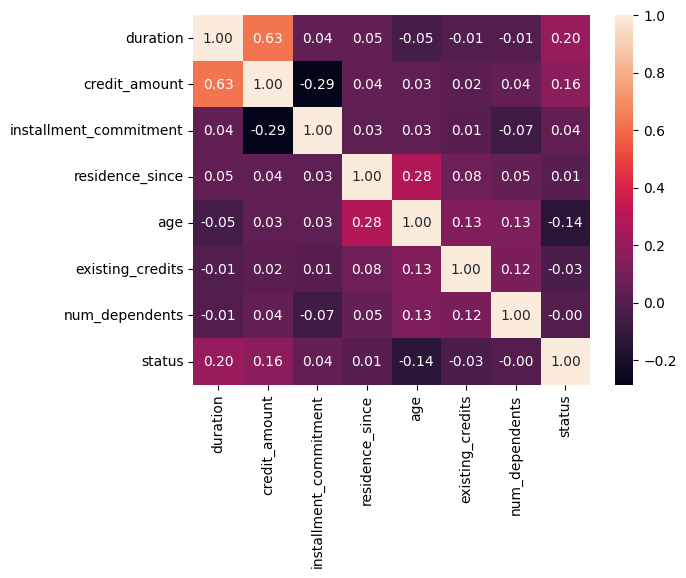

In [257]:
df_corr = df_full_train.corr()
display(round(df_corr,2))
sns.heatmap(df_corr, annot=True, fmt=".2f")

## Model Training

- DecisionTreeClassifier
- RandomForestClassifier
- XGBoost

### DecisionTreeClassifier

#### Training

In [337]:
random_state = 42

train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

dt = DecisionTreeClassifier(random_state=random_state)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_val)
dt_score = roc_auc_score(y_val, y_pred)
dt_score

0.6248246844319776

#### Hyperparameter Tuning

In [326]:
def getDataFrame(score_list: list(), columns: list()) ->pd.DataFrame:
    
    df_score = pd.DataFrame(score_list, columns=columns)
    return df_score.sort_values(by=['auc'], ascending=False).round(3)

In [355]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]
min_sample_leaf = [1, 5, 10, 15, 20, 500, 100, 200]

scores = list()

for depth in tqdm(depths):
    for sample in min_sample_leaf:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=sample, max_features='auto', random_state=42)
        dt.fit(X_train, y_train)
        
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, sample, auc))

  0%|          | 0/10 [00:00<?, ?it/s]

In [356]:
dt_scores = getDataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'auc'])
dt_scores_pivot = dt_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
dt_scores_pivot

auc                                                   \
max_depth           NaN   1.0    2.0    3.0    4.0    5.0    6.0    10.0   
min_samples_leaf                                                           
1                 0.574  0.591  0.626  0.648  0.625  0.553  0.657  0.614   
5                 0.624  0.591  0.626  0.648  0.621  0.570  0.677  0.647   
10                0.689  0.591  0.626  0.648  0.640  0.554  0.678  0.689   
15                0.653  0.591  0.626  0.649  0.619  0.586  0.675  0.653   
20                0.640  0.591  0.626  0.649  0.621  0.607  0.648  0.640   
100               0.664  0.591  0.664  0.664  0.664  0.664  0.664  0.664   
200               0.561  0.561  0.561  0.561  0.561  0.561  0.561  0.561   
500               0.500  0.500  0.500  0.500  0.500  0.500  0.500  0.500   

                                
max_depth          15.0   20.0  
min_samples_leaf                
1                 0.567  0.602  
5                 0.624  0.624  
10                0.689  0.689  
15                0.653  0.653  
20                0.640  0.640  
100               0.664  0.664  
200               0.561  0.561  
500               0.500  0.500

<AxesSubplot: xlabel='None-max_depth', ylabel='min_samples_leaf'>

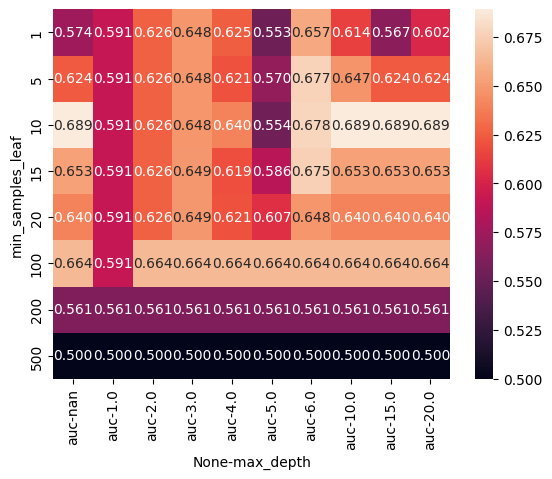

In [357]:
sns.heatmap(dt_scores_pivot, annot=True, fmt=".3f")

### RandomForestClassifier

#### Training

In [340]:
rf = RandomForestClassifier(random_state=random_state)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
rf_score = roc_auc_score(y_val, y_pred)
rf_score

0.6323048153342683

#### Hyperparameter Tuning

In [353]:
rf_scores = list()

for d in tqdm(depths):
    for n in range(10, 201, 10):
        for s in [1, 3, 5, 10, 50]:
            rf = RandomForestClassifier(n_estimators=n, max_depth=d, min_samples_leaf=s, max_features='auto', bootstrap=True, random_state=random_state)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_val)
            rf_score = roc_auc_score(y_val, y_pred)
            rf_scores.append((d, n, s, rf_score))

  0%|          | 0/10 [00:00<?, ?it/s]

In [354]:
rf_df_scores = getDataFrame(rf_scores, columns=['max_depth', 'n_estimator', 'min_samples_leaf', 'auc'])
display(rf_df_scores)

max_depth  n_estimator  min_samples_leaf    auc
785       15.0          180                 1  0.652
790       15.0          190                 1  0.652
780       15.0          170                 1  0.648
795       15.0          200                 1  0.648
816       20.0           40                 3  0.643
..         ...          ...               ...    ...
397        4.0          200                 5  0.496
366        4.0          140                 3  0.496
372        4.0          150                 5  0.496
327        4.0           60                 5  0.496
322        4.0           50                 5  0.493

[1000 rows x 4 columns]

### XGBoost

#### Training

In [370]:
features = dv.get_feature_names()
features_name = list()
for f in features:
    feature = f.replace("<", "").replace(">", "")
    features_name.append(feature)
   
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features_name)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features_name)

xgb_param = {'seed': 42}
model = xgb.train(xgb_param, dtrain)
y_pred = model.predict(dval)
score = roc_auc_score(y_val, y_pred)
score

/Users/premsurawut/.local/share/virtualenvs/midterm-project-E_4i7tNf/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


0.7214820009350165

#### Hyperparameter Tuning

In [427]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [432]:
%%capture output_min_child_weight1

xgb_params = {
    'eta': 0.03,
    'max_depth': 1,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=115, verbose_eval=5, evals=watchlist)


In [435]:
%%capture output_min_child_weight2

xgb_params = {
    'eta': 0.03,
    'max_depth': 1,
    'min_child_weight': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=115, verbose_eval=5, evals=watchlist)

In [436]:
%%capture output_min_child_weight3

xgb_params = {
    'eta': 0.03,
    'max_depth': 1,
    'min_child_weight': 5,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=115, verbose_eval=5, evals=watchlist)

In [438]:
%%capture output_min_child_weight4

xgb_params = {
    'eta': 0.03,
    'max_depth': 1,
    'min_child_weight': 8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=115, verbose_eval=5, evals=watchlist)

In [437]:
%%capture output_min_child_weight5

xgb_params = {
    'eta': 0.03,
    'max_depth': 1,
    'min_child_weight': 10,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=115, verbose_eval=5, evals=watchlist)

In [471]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results.sort_values(by=['val_auc'], ascending=False)

In [472]:
output_min_child_weight = [output_min_child_weight1, output_min_child_weight2, output_min_child_weight3, output_min_child_weight4, output_min_child_weight5]    
min_child_weight = [1, 3, 5, 8, 10]
for output in output_min_child_weight:
    xgb_df_scores = parse_xgb_output(output)
    display(xgb_df_scores)

num_iter  train_auc  val_auc
23       114    0.77376  0.73387
22       110    0.77250  0.73118
21       105    0.77108  0.72750
20       100    0.77090  0.72528
19        95    0.76937  0.72528
16        80    0.76656  0.72411
18        90    0.76888  0.72405
17        85    0.76727  0.72405
14        70    0.76457  0.72142
15        75    0.76611  0.72061
13        65    0.76384  0.72037
12        60    0.76358  0.72014
11        55    0.76179  0.71459
10        50    0.76136  0.71342
9         45    0.75887  0.71248
8         40    0.75483  0.70448
6         30    0.72413  0.66789
5         25    0.72413  0.66789
7         35    0.72705  0.66772
4         20    0.71200  0.66766
1          5    0.66121  0.66129
3         15    0.66121  0.66129
2         10    0.66121  0.66129
0          0    0.66121  0.66129

num_iter  train_auc  val_auc
23       114    0.77376  0.73387
22       110    0.77250  0.73118
21       105    0.77108  0.72750
20       100    0.77090  0.72528
19        95    0.76937  0.72528
16        80    0.76656  0.72411
18        90    0.76888  0.72405
17        85    0.76727  0.72405
14        70    0.76457  0.72142
15        75    0.76611  0.72061
13        65    0.76384  0.72037
12        60    0.76358  0.72014
11        55    0.76179  0.71459
10        50    0.76136  0.71342
9         45    0.75887  0.71248
8         40    0.75483  0.70448
6         30    0.72413  0.66789
5         25    0.72413  0.66789
7         35    0.72705  0.66772
4         20    0.71200  0.66766
1          5    0.66121  0.66129
3         15    0.66121  0.66129
2         10    0.66121  0.66129
0          0    0.66121  0.66129

num_iter  train_auc  val_auc
23       114    0.77376  0.73387
22       110    0.77250  0.73118
21       105    0.77108  0.72750
20       100    0.77090  0.72528
19        95    0.76937  0.72528
16        80    0.76656  0.72411
18        90    0.76888  0.72405
17        85    0.76727  0.72405
14        70    0.76457  0.72142
15        75    0.76611  0.72061
13        65    0.76384  0.72037
12        60    0.76358  0.72014
11        55    0.76179  0.71459
10        50    0.76136  0.71342
9         45    0.75887  0.71248
8         40    0.75483  0.70448
6         30    0.72413  0.66789
5         25    0.72413  0.66789
7         35    0.72705  0.66772
4         20    0.71200  0.66766
1          5    0.66121  0.66129
3         15    0.66121  0.66129
2         10    0.66121  0.66129
0          0    0.66121  0.66129

num_iter  train_auc  val_auc
22       110    0.76694  0.73416
23       114    0.76801  0.73410
21       105    0.76512  0.73101
20       100    0.76453  0.72750
19        95    0.76226  0.72657
18        90    0.76156  0.72586
17        85    0.76217  0.72534
14        70    0.75966  0.72475
16        80    0.76098  0.72464
13        65    0.75676  0.72364
12        60    0.75706  0.72364
15        75    0.76058  0.72312
11        55    0.75661  0.72177
10        50    0.75258  0.71798
9         45    0.75325  0.71447
8         40    0.75309  0.71342
7         35    0.73718  0.68583
6         30    0.71275  0.66795
5         25    0.71275  0.66795
4         20    0.71200  0.66766
1          5    0.66121  0.66129
3         15    0.66121  0.66129
2         10    0.66121  0.66129
0          0    0.66121  0.66129

num_iter  train_auc  val_auc
22       110    0.76694  0.73416
23       114    0.76801  0.73410
21       105    0.76512  0.73101
20       100    0.76453  0.72750
19        95    0.76226  0.72657
18        90    0.76156  0.72586
17        85    0.76217  0.72534
14        70    0.75966  0.72475
16        80    0.76098  0.72464
13        65    0.75676  0.72364
12        60    0.75706  0.72364
15        75    0.76058  0.72312
11        55    0.75661  0.72177
10        50    0.75258  0.71798
9         45    0.75325  0.71447
8         40    0.75309  0.71342
7         35    0.73718  0.68583
6         30    0.71275  0.66795
5         25    0.71275  0.66795
4         20    0.71200  0.66766
1          5    0.66121  0.66129
3         15    0.66121  0.66129
2         10    0.66121  0.66129
0          0    0.66121  0.66129

In [441]:
%%capture output_max_depth1

xgb_params = {
    'eta': 0.03,
    'max_depth': 1,
    'min_child_weight': 8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=115, verbose_eval=5, evals=watchlist)

In [442]:
%%capture output_max_depth2

xgb_params = {
    'eta': 0.03,
    'max_depth': 3,
    'min_child_weight': 8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=115, verbose_eval=5, evals=watchlist)

In [443]:
%%capture output_max_depth3

xgb_params = {
    'eta': 0.03,
    'max_depth': 5,
    'min_child_weight': 8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=115, verbose_eval=5, evals=watchlist)

In [444]:
%%capture output_max_depth4

xgb_params = {
    'eta': 0.03,
    'max_depth': 8,
    'min_child_weight': 8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=115, verbose_eval=5, evals=watchlist)

In [445]:
%%capture output_max_depth5

xgb_params = {
    'eta': 0.03,
    'max_depth': 10,
    'min_child_weight': 8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=115, verbose_eval=5, evals=watchlist)

In [446]:
output_max_depth = [output_max_depth1, output_max_depth2, output_max_depth3, output_max_depth4, output_max_depth5]    
for output in output_max_depth:    
    xgb_df_scores = parse_xgb_output(output)
    display(xgb_df_scores)

num_iter  train_auc  val_auc
22       110    0.76694  0.73416
23       114    0.76801  0.73410
21       105    0.76512  0.73101
20       100    0.76453  0.72750
19        95    0.76226  0.72657
18        90    0.76156  0.72586
17        85    0.76217  0.72534
14        70    0.75966  0.72475
16        80    0.76098  0.72464
13        65    0.75676  0.72364
12        60    0.75706  0.72364
15        75    0.76058  0.72312
11        55    0.75661  0.72177
10        50    0.75258  0.71798
9         45    0.75325  0.71447
8         40    0.75309  0.71342
7         35    0.73718  0.68583
6         30    0.71275  0.66795
5         25    0.71275  0.66795
4         20    0.71200  0.66766
1          5    0.66121  0.66129
3         15    0.66121  0.66129
2         10    0.66121  0.66129
0          0    0.66121  0.66129

num_iter  train_auc  val_auc
18        90    0.86799  0.75351
20       100    0.87217  0.75339
17        85    0.86460  0.75339
19        95    0.87015  0.75292
21       105    0.87461  0.75257
22       110    0.87578  0.75222
16        80    0.86163  0.75210
14        70    0.85515  0.75187
23       114    0.87788  0.75105
15        75    0.85943  0.75058
12        60    0.84837  0.75047
13        65    0.85142  0.74988
11        55    0.84300  0.74760
10        50    0.83912  0.74573
9         45    0.83339  0.74188
8         40    0.82877  0.74077
7         35    0.82446  0.73416
6         30    0.81599  0.72394
5         25    0.81282  0.71961
4         20    0.81108  0.71722
3         15    0.80406  0.71260
0          0    0.76047  0.70763
2         10    0.79564  0.70144
1          5    0.78443  0.67935

num_iter  train_auc  val_auc
23       114    0.90317  0.75058
22       110    0.90195  0.74883
21       105    0.89997  0.74825
20       100    0.89793  0.74778
19        95    0.89539  0.74568
17        85    0.89076  0.74486
16        80    0.88819  0.74439
18        90    0.89364  0.74392
15        75    0.88550  0.74182
13        65    0.87761  0.74135
11        55    0.86829  0.74112
14        70    0.88167  0.74088
12        60    0.87311  0.74053
10        50    0.86355  0.73942
9         45    0.86064  0.73884
8         40    0.85595  0.73860
7         35    0.85504  0.73510
6         30    0.85195  0.73194
5         25    0.84807  0.72960
4         20    0.84531  0.72487
3         15    0.83548  0.72148
2         10    0.82934  0.71885
0          0    0.78836  0.71546
1          5    0.81865  0.70582

num_iter  train_auc  val_auc
21       105    0.90809  0.75631
23       114    0.91310  0.75608
22       110    0.91100  0.75468
20       100    0.90600  0.75421
19        95    0.90318  0.75339
18        90    0.89983  0.75304
17        85    0.89700  0.75129
16        80    0.89338  0.74977
15        75    0.88912  0.74953
14        70    0.88576  0.74836
13        65    0.88190  0.74661
12        60    0.87879  0.74655
10        50    0.86937  0.74655
11        55    0.87335  0.74644
8         40    0.86266  0.74626
9         45    0.86487  0.74544
7         35    0.86266  0.74322
6         30    0.85762  0.74170
5         25    0.85592  0.73305
4         20    0.85046  0.72586
3         15    0.84241  0.72142
2         10    0.83070  0.71722
0          0    0.78836  0.71546
1          5    0.81865  0.70582

num_iter  train_auc  val_auc
21       105    0.90809  0.75631
23       114    0.91310  0.75608
22       110    0.91100  0.75468
20       100    0.90600  0.75421
19        95    0.90318  0.75339
18        90    0.89983  0.75304
17        85    0.89700  0.75129
16        80    0.89338  0.74977
15        75    0.88912  0.74953
14        70    0.88576  0.74836
13        65    0.88190  0.74661
12        60    0.87879  0.74655
10        50    0.86937  0.74655
11        55    0.87335  0.74644
8         40    0.86266  0.74626
9         45    0.86487  0.74544
7         35    0.86266  0.74322
6         30    0.85762  0.74170
5         25    0.85592  0.73305
4         20    0.85046  0.72586
3         15    0.84241  0.72142
2         10    0.83070  0.71722
0          0    0.78836  0.71546
1          5    0.81865  0.70582

In [447]:
%%capture output_eta1

xgb_params = {
    'eta': 0.01,
    'max_depth': 8,
    'min_child_weight': 8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=115, verbose_eval=5, evals=watchlist)

In [448]:
%%capture output_eta2

xgb_params = {
    'eta': 0.03,
    'max_depth': 8,
    'min_child_weight': 8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=115, verbose_eval=5, evals=watchlist)

In [449]:
%%capture output_eta3

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'min_child_weight': 8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=115, verbose_eval=5, evals=watchlist)

In [450]:
%%capture output_eta4

xgb_params = {
    'eta': 0.08,
    'max_depth': 8,
    'min_child_weight': 8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=115, verbose_eval=5, evals=watchlist)

In [451]:
%%capture output_eta5

xgb_params = {
    'eta': 0.10,
    'max_depth': 8,
    'min_child_weight': 8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, num_boost_round=115, verbose_eval=5, evals=watchlist)

In [462]:
output_eta = [output_eta1, output_eta2, output_eta3, output_eta4, output_eta5]    
for output in output_eta: 
    xgb_df_scores = parse_xgb_output(output)
    display(xgb_df_scores)

num_iter  train_auc  val_auc
23       114    0.86327  0.74392
22       110    0.86221  0.74381
20       100    0.86014  0.74287
21       105    0.86095  0.74264
19        95    0.85911  0.74205
18        90    0.85811  0.73784
17        85    0.85685  0.73597
16        80    0.85579  0.73364
15        75    0.85404  0.73235
14        70    0.85267  0.72768
13        65    0.85132  0.72464
12        60    0.85084  0.72452
11        55    0.84833  0.72049
10        50    0.84688  0.72014
9         45    0.84157  0.71716
1          5    0.80262  0.71675
8         40    0.84033  0.71663
6         30    0.83397  0.71599
0          0    0.78836  0.71546
7         35    0.83792  0.71523
5         25    0.82981  0.71359
4         20    0.82450  0.71348
3         15    0.81999  0.70950
2         10    0.81129  0.70255

num_iter  train_auc  val_auc
21       105    0.90809  0.75631
23       114    0.91310  0.75608
22       110    0.91100  0.75468
20       100    0.90600  0.75421
19        95    0.90318  0.75339
18        90    0.89983  0.75304
17        85    0.89700  0.75129
16        80    0.89338  0.74977
15        75    0.88912  0.74953
14        70    0.88576  0.74836
13        65    0.88190  0.74661
12        60    0.87879  0.74655
10        50    0.86937  0.74655
11        55    0.87335  0.74644
8         40    0.86266  0.74626
9         45    0.86487  0.74544
7         35    0.86266  0.74322
6         30    0.85762  0.74170
5         25    0.85592  0.73305
4         20    0.85046  0.72586
3         15    0.84241  0.72142
2         10    0.83070  0.71722
0          0    0.78836  0.71546
1          5    0.81865  0.70582

num_iter  train_auc  val_auc
15        75    0.91720  0.75690
14        70    0.91393  0.75444
19        95    0.92837  0.75362
16        80    0.92041  0.75245
21       105    0.93224  0.75234
18        90    0.92597  0.75234
17        85    0.92376  0.75187
20       100    0.93033  0.75152
13        65    0.91119  0.75129
11        55    0.90048  0.75117
22       110    0.93335  0.74988
12        60    0.90681  0.74965
23       114    0.93550  0.74906
10        50    0.89558  0.74801
6         30    0.87002  0.74480
5         25    0.86507  0.74328
9         45    0.88920  0.74299
7         35    0.88046  0.74199
4         20    0.86139  0.74042
8         40    0.88413  0.74007
3         15    0.85502  0.73264
2         10    0.84661  0.72324
0          0    0.78836  0.71546
1          5    0.83125  0.70927

num_iter  train_auc  val_auc
12        60    0.92877  0.75690
11        55    0.92408  0.75468
13        65    0.93303  0.75374
14        70    0.93689  0.75351
10        50    0.92024  0.75327
9         45    0.91538  0.75175
15        75    0.93950  0.75164
17        85    0.94502  0.75164
18        90    0.95037  0.75094
19        95    0.95308  0.74988
8         40    0.90910  0.74953
16        80    0.94171  0.74953
20       100    0.95612  0.74813
7         35    0.90235  0.74778
21       105    0.95831  0.74673
6         30    0.89409  0.74638
22       110    0.96068  0.74345
23       114    0.96323  0.74334
5         25    0.88626  0.74305
4         20    0.87471  0.74299
3         15    0.86181  0.74264
2         10    0.85607  0.73428
1          5    0.83975  0.72207
0          0    0.78836  0.71546

num_iter  train_auc  val_auc
10        50    0.93142  0.75468
9         45    0.92729  0.75456
7         35    0.91697  0.75339
11        55    0.93735  0.75175
8         40    0.92411  0.75000
17        85    0.96040  0.74977
6         30    0.90768  0.74965
15        75    0.95410  0.74906
12        60    0.94185  0.74860
16        80    0.95760  0.74801
19        95    0.96677  0.74755
13        65    0.94731  0.74743
14        70    0.95163  0.74743
18        90    0.96310  0.74743
4         20    0.88836  0.74457
2         10    0.86214  0.74287
5         25    0.89717  0.74264
22       110    0.97253  0.74123
21       105    0.97106  0.74088
3         15    0.87292  0.74077
20       100    0.96911  0.74042
23       114    0.97407  0.74018
1          5    0.84839  0.72943
0          0    0.78836  0.71546

### Model Selection

- compare each final model after hyperparameter tuning

In [478]:
dt_final = DecisionTreeClassifier(max_depth=None, min_samples_leaf=10, max_features='auto', random_state=random_state)
dt_final.fit(X_train, y_train)
y_pred = dt_final.predict(X_val)
dt_final_score = roc_auc_score(y_val, y_pred)

In [479]:
rf_final = RandomForestClassifier(n_estimators=180, max_depth=15, min_samples_leaf=1, max_features='auto',
                                  bootstrap=True, random_state=random_state)
rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_val)
rf_final_score = roc_auc_score(y_val, y_pred)

In [453]:
%%capture xgb_output_final

xgb_params = {
    'eta': 0.08,
    'max_depth': 8,
    'min_child_weight': 8,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 42,
    'verbosity': 1,
}
final_model = xgb.train(xgb_params, dtrain, num_boost_round=115, verbose_eval=5, evals=watchlist)
y_pred = model.predict(dval)
xgb_score = roc_auc_score(y_val, y_pred)

In [481]:
print(f'DecisionTree roc_auc_score: {round(dt_final_score, 3)}\nRandomForest roc_auc_score: {round(rf_final_score, 3)}\nXGBoosting roc_auc_score: {round(xgb_score, 3)}')

DecisionTree roc_auc_score: 0.624
RandomForest roc_auc_score: 0.652
XGBoosting roc_auc_score: 0.74
